# 06 — Konwolucje i CNN: od filtrów do uczenia cech

Ten notebook jest zbudowany w stylu „**od intuicji → do eksperymentu → do CNN**”.

**Po tych zajęciach potrafisz:**
- rozumieć **co robi kernel** i jak powstaje **jeden piksel wyniku**,
- umieć wyjaśnić rolę **padding / stride / dilation** (i policzyć rozmiary wyjścia),
- wiedzieć, dlaczego w DL często mówi się „konwolucja”, choć implementujemy **korelację (cross‑correlation)**,
- rozumieć, czym są **feature maps** i dlaczego **ReLU + pooling** są potrzebne,
- złożyć i przetrenować prostą **CNN** (PyTorch) na klasycznym zbiorze obrazów.

**Uwaga praktyczna (ważne!):**  
W bibliotekach DL (`Conv2d` w PyTorch/TensorFlow) „konwolucja” jest zwykle zaimplementowana jako **korelacja** (bez odwracania kernela).  
Dydaktycznie to nie problem — uczymy się *tego samego mechanizmu „okno × kernel → suma”*. Różni się tylko flip kernela.

> Sekcje oznaczone ⭐ możesz potraktować jako *opcjonalne* (dla chętnych / jeśli starczy czasu).




> **Uwaga techniczna:** notebook korzysta z plików z folderu `images/` (wykresy, gify, schematy). Trzymaj folder obok notebooka.


# Pytania kontrolne - można pominąć - w zależności od czasu na zajęciach

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(0)

# (opcjonalnie) ładniejsze wykresy
plt.rcParams["figure.dpi"] = 120


## Konwolucje (sploty)
### Intuicja, wzory i zastosowania

## O co chodzi? (intuicja)

- **Konwolucja (splot)** łączy:
  - **dane** (sygnał, obraz)
  - **filtr / jądro (kernel)**
- Intuicyjnie: **przesuwasz kernel po danych** i w każdym położeniu liczysz „dopasowanie”.
- Wynik mówi:
  - **gdzie** występuje dany wzorzec
  - **jak silnie** on występuje

## Rysunek: przesuwanie kernela (1D)

```
dane x:     [ x0 ][ x1 ][ x2 ][ x3 ][ x4 ][ x5 ][ x6 ]
kernel h:          [ h0 ][ h1 ][ h2 ]
wynik y:           y2    y3    y4    ...

Dla położenia n = 3:
y[3] = x[1]*h[2] + x[2]*h[1] + x[3]*h[0]
```

(kernel jest odwrócony)

## Definicja konwolucji (ciągła)

$
(f * g)(t) = \int_{-\infty}^{\infty} f(\tau)\, g(t-\tau)\, d\tau
$

- f(τ) — dane (sygnał)
- g(t−τ) — filtr (odwrócony i przesunięty)
- całka = suma lokalnych „dopasowań”

## Rysunek: nakładanie funkcji (schemat)

```
oś τ:   ─────────────────────────────────────────▶

f(τ):        /\      /\        /\
            /  \    /  \      /  \
           /    \  /    \    /    \
          /      \/      \__/      \__

g(t−τ):                 __
                      _/  \_
                     /      \
                    /        \_

Konwolucja:
(f*g)(t) = ∫ f(τ) · g(t−τ) dτ
```

## Definicja konwolucji (dyskretna)

$
(x * h)[n] = \sum_{k=-\infty}^{\infty} x[k]\; h[n-k]
$

- x[k] — dane
- h[n−k] — kernel (odwrócony)
- w praktyce: suma po małym, skończonym zakresie

## Rysunek: schemat blokowy

```
      x[k] ──┐
             ├─(×)─►  Σ_k  ─►  y[n] = (x*h)[n]
  h[n−k] ────┘
```

## Konwolucja vs korelacja

### Konwolucja

$
(x*h)[n] = \sum_k x[k]\;h[n-k]
$

- kernel jest **odwracany**
- poprawna fizycznie dla układów LTI

### Korelacja

$(x ⋆ h)[n] = \sum_k x[k]\;h[n+k]$

- brak odwrócenia kernela
- mierzy podobieństwo wzorców

> W CNN często liczy się korelację, ale nazywa ją „konwolucją”.


> **Praktyczna uwaga (DL):** większość bibliotek (w tym PyTorch) implementuje w warstwach `Conv*` w rzeczywistości **korelację** (bez odwracania kernela), ale historycznie i zwyczajowo nazywa to „konwolucją”.  
> Dla uczenia filtrów nie ma to dużej różnicy — sieć i tak nauczy się wag w takiej orientacji, jaka jest potrzebna.


## Konwolucja 2D (obrazy)
$Y[i,j] = \sum_u \sum_v X[i-u,\,j-v]\;K[u,v]
$

- X — obraz
- K — kernel (np. 3×3)
- każde położenie kernela → jeden piksel wyniku

## Konwolucja 2D – przesuwanie kernela

1. Kernel (np. 3×3) nakładany jest na fragment obrazu
2. Każdy piksel jest mnożony przez wagę kernela
3. Suma daje jeden piksel obrazu wynikowego
4. Kernel przesuwa się po całym obrazie

## Rysunek: kernel 3×3 na obrazie
![movingKernel.gif](images/movingKernel.gif)
![crosscorrelation1.gif](images/crosscorrelation1.gif)
```
Obraz X (5×5):
+---+---+---+---+---+
|   |   |   |   |   |
+---+---+---+---+---+
|   | [ ] [ ] [ ]   |
+---+---+---+---+---+
|   | [ ] [ ] [ ]   |  ← aktywne okno 3×3
+---+---+---+---+---+
|   | [ ] [ ] [ ]   |
+---+---+---+---+---+
|   |   |   |   |   |
+---+---+---+---+---+

Y[i,j] = suma( X * K ) po zaznaczonym oknie
```

💡 Jeśli masz w folderze `images/` animacje (np. z `images.zip`), możesz też zobaczyć wersje animowane:

![moving kernel (1D)](images/movingKernel.gif)

![cross-correlation](images/crosscorrelation.gif)

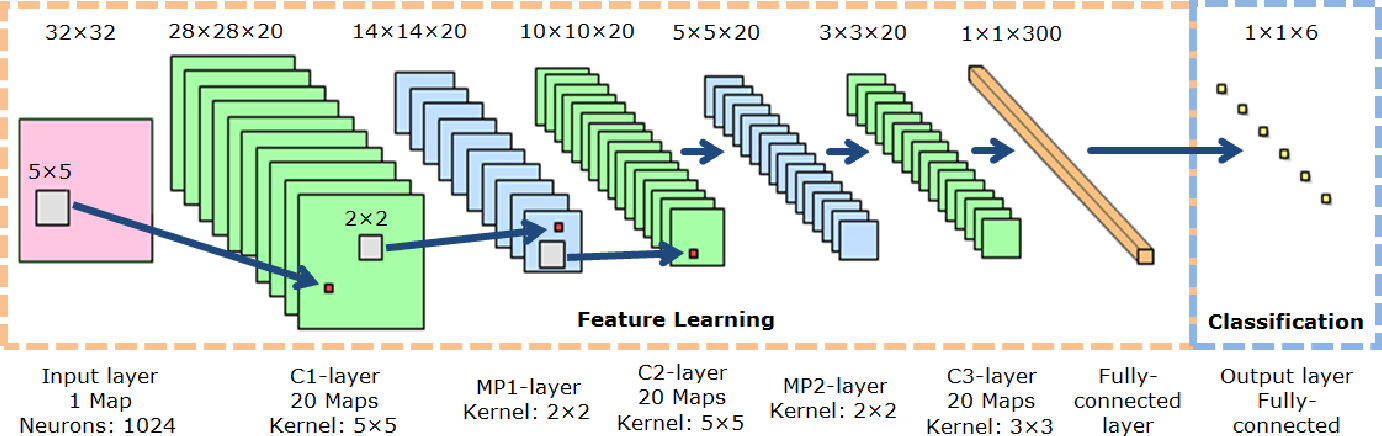

## Przykładowe jądra (maski)

### Rozmycie (średnia)

$
\frac{1}{9}\begin{bmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1
\end{bmatrix}
$

### Wyostrzanie

$
\begin{bmatrix}
0 & -1 & 0\\
-1 & 5 & -1\\
0 & -1 & 0
\end{bmatrix}
$

### Krawędzie (Sobel X)

$
\begin{bmatrix}
-1 & 0 & 1\\
-2 & 0 & 2\\
-1 & 0 & 1
\end{bmatrix}
$

## CNN: od krawędzi do obiektów

- wczesne warstwy: krawędzie, kąty
- środkowe warstwy: tekstury
- głębokie warstwy: części obiektów
- najgłębsze: obiekty i klasy

## Do zapamiętania

**Konwolucja = przesuwanie kernela + sumowanie iloczynów**
m

## Korelacja vs konwolucja: to samo okno, inny kernel

**Korelacja**: kernel bez odwrócenia  
$
(x \star h)[n] = \sum_k x[n+k]\;h[k]
$

**Konwolucja**: kernel odwrócony (flip)  
$
(x * h)[n] = \sum_k x[n-k]\;h[k]
$
(co jest równoważne: „przesuwasz po danych kernel odwrócony”)

![konwolucja_vs_korelacja_1D.png](images/konwolucja_vs_korelacja_1D.png)



## Konwolucja 2D: jak liczymy jeden piksel wyniku?

1. Bierzemy okno obrazu $3\times3$
2. Mnożymy element-po-elemencie przez kernel
3. Sumujemy → dostajemy jedną liczbę (jeden piksel wyniku)

![konwolucja_2D_jeden_piksel.png](images/konwolucja_2D_jeden_piksel.png)






# Ćwiczenie 0 – Obraz jako macierz

## Opis
Obraz cyfrowy **nie jest „zdjęciem”**, lecz **tablicą liczb**.  
W przypadku obrazu w skali szarości każdemu pikselowi odpowiada **jedna liczba** opisująca jego jasność.

- `0` – czarny piksel  
- `1` – biały piksel (maksymalna jasność)  
- wartości pośrednie – odcienie szarości  

Matematycznie obraz jest **macierzą liczb rzeczywistych**.

---

## Zadanie
1. Wygeneruj proste obrazy testowe zapisane jako macierze.
2. Wyświetl je w skali szarości.
3. Sprawdź:
   - rozmiar tablic (`shape`),
   - typ danych (`dtype`),
   - wybrane wartości pikseli.

---

## Dane testowe
Wygenerowane obrazy zawierają **proste figury geometryczne**, które będą później wykorzystywane do analizy działania konwolucji:

- pusty obraz (brak sygnału),
- kwadrat,
- linia pionowa,
- linia pozioma,
- krzyż (suma wzorców),
- szachownica o polach 1×1 piksel (bardzo wysoka częstotliwość),
- szachownica o polach `block × block` pikseli (kontrolowana skala wzoru).

Każdy obraz ma rozmiar `size × size` i jest zapisany jako macierz typu `float32`.

---

## Cel ćwiczenia
- Zrozumienie, że **piksel = liczba**, a obraz = **macierz liczb**.
- Uświadomienie, że algorytmy (w tym sieci neuronowe) **nie „widzą obrazu”**, lecz operują na tablicach.
- Przygotowanie do wykonywania **lokalnych operacji matematycznych na obrazach** (konwolucja).

---

## Oczekiwany wynik
- Widoczne proste figury geometryczne w skali szarości.
- Świadomość, że:
  - obraz ma określony rozmiar i typ danych,
  - każda operacja na obrazie jest operacją na liczbach.

---

## Pytania kontrolne
1. Jaki jest rozmiar macierzy opisującej obraz?
2. Co oznacza pojedyncza liczba w tej macierzy?
3. Czy komputer „widzi” figury geometryczne, czy tylko liczby?
4. Który obraz zawiera najszybsze zmiany jasności i dlaczego?
5. Jak zmienia się szachownica, gdy zwiększamy parametr `block`?

---

## Zapowiedź kolejnego ćwiczenia
> W następnym ćwiczeniu będziemy wykonywać **lokalne operacje matematyczne** na takich macierzach i obserwować, jak zmienia się obraz.  
> To będzie pierwsze spotkanie z **konwolucją**.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def checkerboard(size=128, block=8):
    """
    Generuje szachownicę o polach block x block.
    
    size  – rozmiar obrazu (size x size)
    block – rozmiar jednego pola szachownicy
    """
    I, J = np.indices((size, size))
    board = (I // block + J // block) % 2
    return board.astype(np.float32)

def test_images(size=128):
    imgs = {}

    imgs["empty"] = np.zeros((size, size), dtype=np.float32)

    img = np.zeros((size, size), dtype=np.float32)
    img[32:96, 32:96] = 1.0
    imgs["square"] = img

    img = np.zeros((size, size), dtype=np.float32)
    img[:, size//2-2:size//2+2] = 1.0
    imgs["vertical_line"] = img

    img = np.zeros((size, size), dtype=np.float32)
    img[size//2-2:size//2+2, :] = 1.0
    imgs["horizontal_line"] = img

    img = np.zeros((size, size), dtype=np.float32)
    img[:, size//2-2:size//2+2] = 1.0
    img[size//2-2:size//2+2, :] = 1.0
    imgs["cross"] = img

    img = np.indices((size, size)).sum(axis=0) % 2
    imgs["checkerboard"] = img.astype(np.float32)

    img = checkerboard(size=size, block=8)
    imgs['checkerboard_block'] = img 
    return imgs


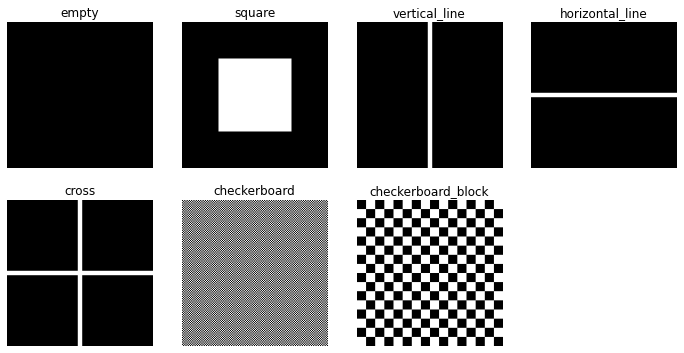

In [3]:
imgs = test_images()

plt.figure(figsize=(12,6))
for i, (name, img) in enumerate(imgs.items(), 1):
    plt.subplot(2, 4, i)
    plt.imshow(img, cmap="gray")
    plt.title(name)
    plt.axis("off")
plt.show()




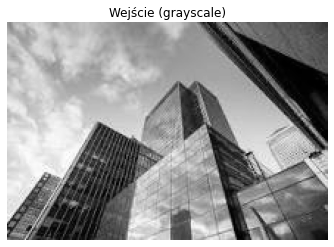

In [4]:
#Wczytanie obrazu
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open("images/obrazek.jpg").convert("L")  # L = grayscale
x = np.array(img, dtype=np.float32) / 255.0

plt.imshow(x, cmap="gray")
plt.title("Wejście (grayscale)")
plt.axis("off")
plt.show()

### (Opcjonalnie) Ten sam filtr na innym obrazie

Budynek jest świetny do krawędzi i geometrii.  
Dla kontrastu możesz też użyć innego obrazu (tekstury, twarz, tło).

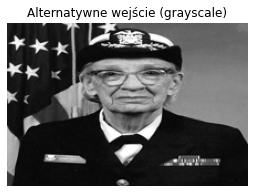

In [5]:
import matplotlib.cbook as cbook
import matplotlib.image as mpimg
from PIL import Image

# Matplotlib ma wbudowany obrazek 'grace_hopper.jpg' (offline).
with cbook.get_sample_data('grace_hopper.jpg') as f:
    img_rgb = mpimg.imread(f)

# mpimg.imread dla JPG bywa uint8 albo float w [0,1] — obsługujemy oba przypadki.
arr = img_rgb
if arr.dtype != np.uint8:
    arr = (arr * 255).clip(0, 255).astype(np.uint8)

# do skali szarości + rozmiar jak 'obrazek.jpg' (żeby naiwna konwolucja była szybka)
img = Image.fromarray(arr).convert("L").resize((218, 148))
x_alt = np.array(img, dtype=np.float32) / 255.0

plt.figure(figsize=(6,3))
plt.imshow(x_alt, cmap="gray")
plt.title("Alternatywne wejście (grayscale)")
plt.axis("off")
plt.show()


# Ćwiczenie 1 – Prosta konwolucja 2D (`valid`)

## Opis
W tym ćwiczeniu implementujesz **konwolucję 2D bez paddingu** (tryb `valid`).  
Oznacza to, że liczysz wynik tylko tam, gdzie kernel **w całości mieści się w obrazie wejściowym**.

Uwaga terminologiczna: implementowana operacja **nie odwraca kernela**, więc technicznie jest to **korelacja**.  
W deep learning to jednak standardowo nazywa się „konwolucją” (tak jest w większości bibliotek DL).

---

## Zadanie
1. Zaimplementuj funkcję `conv2d_valid(x, k)`.  
2. Zastosuj filtr rozmywający (średnia 3×3) do obrazu `square`.  
3. Porównaj rozmiary wejścia i wyjścia (`shape`).  

---

## Pseudokod (rdzeń algorytmu)

```text
kh, kw = k.shape
H, W   = x.shape
H_out = H - kh + 1
W_out = W - kw + 1

dla i=0..H_out-1:
  dla j=0..W_out-1:
    patch = x[i:i+kh, j:j+kw]
    y[i,j] = suma(patch * k)
```



### Słowniczek zmiennych (dla `conv2d_valid`)

W implementacji będziemy używać typowych nazw:

- $x$ — obraz wejściowy (macierz) o rozmiarze $H\times W$  
- $k$ — kernel / filtr o rozmiarze $k_H\times k_W$  
- `H, W = x.shape` — wymiary wejścia  
- `kH, kW = k.shape` — wymiary kernela  
- $y$ — wynik konwolucji (mapa cech) o rozmiarze $H_{out}\times W_{out}$  

**Tryb `valid` (bez paddingu):**

$$
H_{out} = H - k_H + 1,\qquad W_{out} = W - k_W + 1.
$$

Jeden piksel wyniku liczymy tak:

1) bierzemy okno (patch) `x[i:i+kH, j:j+kW]`  
2) mnożymy element‑po‑elemencie przez kernel `k`  
3) sumujemy → dostajemy `y[i, j]`

![conv2d_param_diagram](images/conv2d_param_diagram.png)

Dodatkowo (intuicja „patch × kernel → 1 liczba”):

![patch_kernel_output](images/2.png)


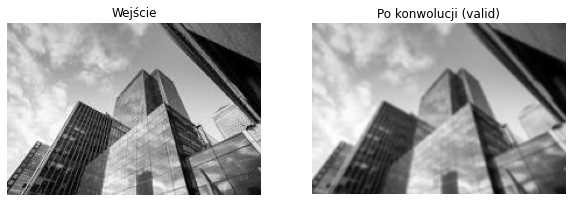

(148, 218)
(146, 216)


In [6]:
def conv2d_valid(x, k):
    # x: HxW, k: khxkw
    kh, kw = k.shape
    H, W = x.shape
    out_h, out_w = H - kh + 1, W - kw + 1
    y = np.zeros((out_h, out_w), dtype=np.float32)

    for i in range(out_h):
        for j in range(out_w):
            patch = x[i:i+kh, j:j+kw]
            y[i, j] = np.sum(patch * k)
    return y

# przykład: rozmycie (średnia 3x3)
k_blur = np.ones((3,3), dtype=np.float32) / 9.0
y = conv2d_valid(x, k_blur)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(x, cmap="gray"); plt.title("Wejście"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(y, cmap="gray"); plt.title("Po konwolucji (valid)"); plt.axis("off")
plt.show()
print(x.shape)
print(y.shape)


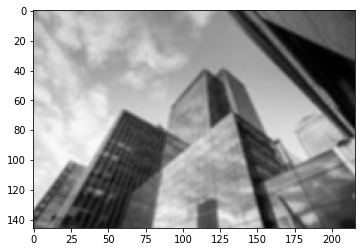

In [7]:
plt.imshow(y, cmap="gray", vmin=0, vmax=1)

In [8]:
np.ones((3,3), dtype=np.float32)

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]], dtype=float32)

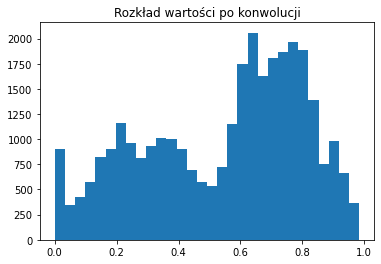

In [9]:
plt.hist(y.ravel(), bins=30)
plt.title("Rozkład wartości po konwolucji")
plt.show()

## Krótkie pytania kontrolne

---

### 1. Co oznacza tryb `valid`?
**Odpowiedź:**  
Obliczamy wynik tylko tam, gdzie kernel w całości mieści się w obrazie. Nie stosujemy paddingu.

---

### 2. Dlaczego obraz wynikowy jest mniejszy?
**Odpowiedź:**  
Ponieważ na brzegach kernel wychodziłby poza obraz, więc te pozycje są pomijane.

---

### 3. Co zawiera `patch`?
**Odpowiedź:**  
Fragment obrazu wejściowego o takim samym rozmiarze jak kernel.

---

### 4. Jaką operację wykonuje `patch * k`?
**Odpowiedź:**  
Mnożenie element-po-elemencie (nie iloczyn macierzy).

---

### 5. Co reprezentuje `y[i, j]`?
**Odpowiedź:**  
Lokalną sumę iloczynów pikseli z okna obrazu i wag kernela.

---

### 6. Dlaczego filtr 3×3 rozmywa krawędzie?
**Odpowiedź:**  
Ponieważ uśrednia wartości jasnych i ciemnych pikseli w lokalnym sąsiedztwie.

---

### 7. Dlaczego suma wag kernela wynosi 1?
**Odpowiedź:**  
Aby zachować średnią jasność obrazu (bez globalnego rozjaśniania lub ściemniania).

---

### 8. Co należałoby zmienić, aby wynik miał ten sam rozmiar co wejście?
**Odpowiedź:**  
Dodać padding (`same`).


# Ćwiczenie 2 – Padding (`valid` vs `same`)

## Po co w ogóle padding?

W trybie `valid` kernel może się przesuwać tylko tam, gdzie **w całości mieści się w obrazie**.  
To ma dwie konsekwencje:

1) wynik jest **mniejszy** (po każdej konwolucji tracisz piksele na brzegach),  
2) na brzegach często dzieją się “ważne rzeczy” (krawędzie obiektów), a `valid` ich **nie analizuje** w pełni.

W trybie `same` dodajesz ramkę (padding), żeby kontrolować sytuację na brzegu i (często) zachować rozmiar:

- `same + zero` — poza obrazem są zera (czarna ramka) → może tworzyć artefakty,
- `same + edge` — wartości na brzegu są “przedłużane” → zwykle bardziej naturalnie dla obrazów.

---

## Co zobaczysz w tym ćwiczeniu?

Żeby efekt był **naprawdę widoczny**, zrobimy dwa porównania:

1) **mały obraz testowy** (np. kwadrat) — różnice w paddingu widać od razu,  
2) **duży obraz** (np. budynek) — różnice są głównie na krawędziach, więc pokażemy też *zoom* na brzegi.

---

## Zadanie

1. Wykonaj konwolucję `valid`.  
2. Wykonaj konwolucję `same` z paddingiem `edge` i `zero`.  
3. Porównaj rozmiary i wyniki (zwłaszcza przy brzegach).

---

## Pytania kontrolne

1. Dlaczego `valid` zmniejsza rozmiar obrazu?  
2. Dlaczego różnica między `same + zero` i `same + edge` jest największa na brzegach?  
3. Kiedy `same` daje dokładnie ten sam rozmiar co wejście?



### Ściąga: rozmiar wyjścia konwolucji / pooling

Dla wejścia o wymiarach $H \times W$, kernela $k_H \times k_W$, paddingu $p$, stride $s$ (bez dilation):

$$
H_{out}=\left\lfloor \frac{H + 2p - k_H}{s} \right\rfloor + 1,
\qquad
W_{out}=\left\lfloor \frac{W + 2p - k_W}{s} \right\rfloor + 1
$$

**Ważne przypadki:**
- `valid`: $p=0$ → rozmiar zwykle maleje,
- `same` (dla nieparzystego kernela i stride=1): dobieramy $p=\lfloor k/2 \rfloor$ → $H_{out}=H$, $W_{out}=W$.

✅ Na zajęciach: zawsze rób szybki *sanity‑check* kształtów po każdej warstwie (tak jak w RL sprawdzasz shape obserwacji).



### Rozmiary wyjścia — wersja „pełna” (stride + padding + dilation)

W praktyce (PyTorch, TensorFlow) rozmiar wyjścia zależy od **pięciu** rzeczy:

- wejście: $H \times W$
- kernel: $k_H \times k_W$
- padding: $p_H, p_W$
- stride: $s_H, s_W$
- dilation: $d_H, d_W$

Najpierw liczysz **efektywny rozmiar kernela** (po dylatacji):

$$
k^{eff}_H = d_H\,(k_H-1)+1,\qquad k^{eff}_W = d_W\,(k_W-1)+1.
$$

A potem:

$$
H_{out}=\left\lfloor \frac{H + 2p_H - k^{eff}_H}{s_H} \right\rfloor + 1,
\qquad
W_{out}=\left\lfloor \frac{W + 2p_W - k^{eff}_W}{s_W} \right\rfloor + 1.
$$

> To jest dokładnie ta arytmetyka, którą w praktyce cały czas sprawdzasz, gdy „nie spina się” wymiar na wejściu do `Linear`.

#### Szybkie przykłady (warto zrobić na żywo)
1) **`same` przy stride=1 i kernelu 3×3 (bez dilation)**  
$H=32,\ k=3,\ p=1,\ s=1$  
$$
H_{out}=\lfloor (32+2\cdot1-3)/1\rfloor+1=32.
$$

2) **`valid` przy kernelu 5×5**  
$H=32,\ k=5,\ p=0,\ s=1$  
$$
H_{out}=\lfloor (32-5)/1\rfloor+1=28.
$$

3) **Stride=2 (downsampling)**  
$H=32,\ k=3,\ p=1,\ s=2$  
$$
H_{out}=\lfloor (32+2-3)/2\rfloor+1 = \lfloor 31/2\rfloor+1 = 15+1=16.
$$

4) **Dylatacja d=2 dla kernela 3×3**  
Efektywnie $k^{eff}=2\cdot(3-1)+1=5$.  
Czyli 3×3 z d=2 „widzi” jak 5×5, ale ma nadal tylko 9 parametrów.

#### Uwaga o `same` przy stride>1
Dla stride>1 różne biblioteki definiują `same` nieco inaczej (czasem przez `ceil`).  
W dydaktyce najbezpieczniej jest trzymać się:
- `same` = „zachowaj rozmiar” **dla stride=1** i **nieparzystego kernela**,
- a dla stride>1 mówić wprost: „to jest downsampling, więc wymiar spadnie mniej więcej ~$\times s$”.


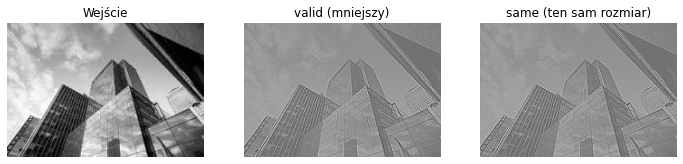

(148, 218)
(146, 216)
(148, 218)


In [10]:
def pad2d(x, pad, mode="edge"):
    # pad: int
    if mode == "zero":
        return np.pad(x, ((pad,pad),(pad,pad)), mode="constant", constant_values=0.0)
    elif mode == "edge":
        return np.pad(x, ((pad,pad),(pad,pad)), mode="edge")
    else:
        raise ValueError("mode must be 'zero' or 'edge'")

def conv2d_same(x, k, pad_mode="edge"):
    kh, kw = k.shape
    assert kh % 2 == 1 and kw % 2 == 1, "Dla 'same' użyj nieparzystych rozmiarów kernela."
    p = kh // 2
    xp = pad2d(x, p, mode=pad_mode)
    return conv2d_valid(xp, k)

k_sharp = np.array([[0,-1,0],
                    [-1,5,-1],
                    [0,-1,0]], dtype=np.float32)

y_valid = conv2d_valid(x, k_sharp)
y_same  = conv2d_same(x, k_sharp, pad_mode="edge")

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(x, cmap="gray"); plt.title("Wejście"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(y_valid, cmap="gray"); plt.title("valid (mniejszy)"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(y_same, cmap="gray"); plt.title("same (ten sam rozmiar)"); plt.axis("off")
plt.show()
print(x.shape)
print(y_valid.shape)
print(y_same.shape)



=== MAŁY OBRAZ: square + kernel sharpen ===
Rozmiary:
x         : (128, 128)
valid     : (126, 126)
same-edge : (128, 128)
same-zero : (128, 128)


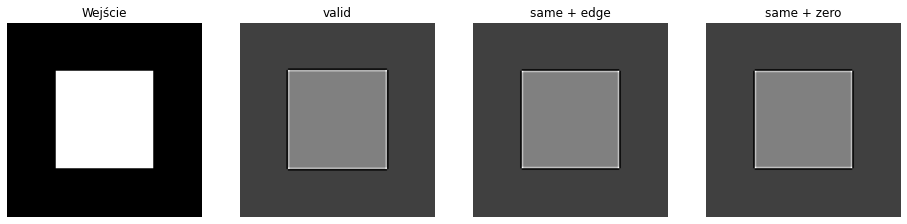

Różnice same-edge vs same-zero:
max |diff|: 0.0
mean|diff|: 0.0


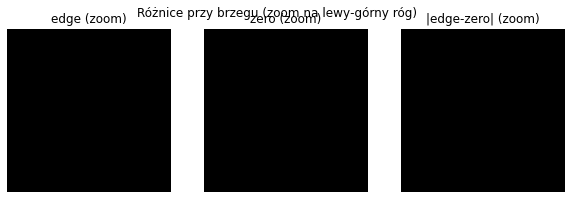


=== DUŻY OBRAZ: building + kernel sharpen ===
Rozmiary:
x         : (148, 218)
valid     : (146, 216)
same-edge : (148, 218)
same-zero : (148, 218)


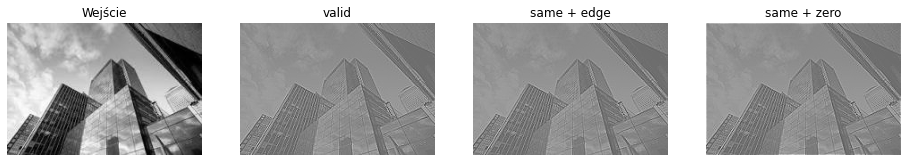

Różnice same-edge vs same-zero:
max |diff|: 1.1921569108963013
mean|diff|: 0.011252511292696


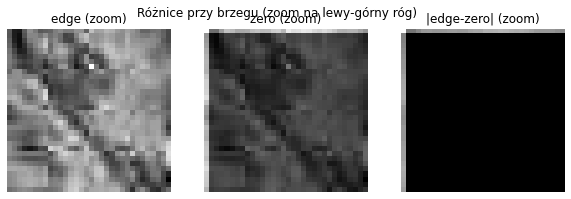

In [11]:
# --- Eksperyment: wpływ trybu paddingu na wynik 'same' ---

def compare_padding(x_in, kernel, title, crop=12):
    """Porównanie valid vs same(edge) vs same(zero) + zoom na brzeg."""
    y_valid = conv2d_valid(x_in, kernel)
    y_same_edge = conv2d_same(x_in, kernel, pad_mode="edge")
    y_same_zero = conv2d_same(x_in, kernel, pad_mode="zero")

    print(f"\n=== {title} ===")
    print("Rozmiary:")
    print("x         :", x_in.shape)
    print("valid     :", y_valid.shape)
    print("same-edge :", y_same_edge.shape)
    print("same-zero :", y_same_zero.shape)

    # Wymuszamy tę samą skalę kolorów, żeby porównanie było uczciwe
    vmin = min(float(y_valid.min()), float(y_same_edge.min()), float(y_same_zero.min()))
    vmax = max(float(y_valid.max()), float(y_same_edge.max()), float(y_same_zero.max()))

    plt.figure(figsize=(16,4))
    plt.subplot(1,4,1); plt.imshow(x_in, cmap="gray", vmin=0, vmax=1); plt.title("Wejście"); plt.axis("off")
    plt.subplot(1,4,2); plt.imshow(y_valid, cmap="gray", vmin=vmin, vmax=vmax); plt.title("valid"); plt.axis("off")
    plt.subplot(1,4,3); plt.imshow(y_same_edge, cmap="gray", vmin=vmin, vmax=vmax); plt.title("same + edge"); plt.axis("off")
    plt.subplot(1,4,4); plt.imshow(y_same_zero, cmap="gray", vmin=vmin, vmax=vmax); plt.title("same + zero"); plt.axis("off")
    plt.show()

    # Różnice ilościowe
    diff = np.abs(y_same_edge - y_same_zero)
    print("Różnice same-edge vs same-zero:")
    print("max |diff|:", float(diff.max()))
    print("mean|diff|:", float(diff.mean()))

    # Zoom: tylko narożnik (tam efekt paddingu jest największy)
    if crop is not None and crop > 0:
        plt.figure(figsize=(10,3))
        plt.subplot(1,3,1); plt.imshow(y_same_edge[:crop,:crop], cmap="gray"); plt.title("edge (zoom)"); plt.axis("off")
        plt.subplot(1,3,2); plt.imshow(y_same_zero[:crop,:crop], cmap="gray"); plt.title("zero (zoom)"); plt.axis("off")
        plt.subplot(1,3,3); plt.imshow(diff[:crop,:crop], cmap="gray"); plt.title("|edge-zero| (zoom)"); plt.axis("off")
        plt.suptitle("Różnice przy brzegu (zoom na lewy‑górny róg)")
        plt.show()

# 1) Najpierw mały obraz testowy (tu różnice widać najlepiej)
x_small = imgs["square"]
compare_padding(x_small, k_sharp, title="MAŁY OBRAZ: square + kernel sharpen", crop=16)

# 2) Potem duży obraz „z życia” (tu różnice są głównie na brzegach)
compare_padding(x, k_sharp, title="DUŻY OBRAZ: building + kernel sharpen", crop=32)


## Wnioski z eksperymentu: `same` z paddingiem `edge` vs `zero`

1. **`same` zachowuje rozmiar obrazu**, bo przed konwolucją dopadujemy wejście:
   - `valid` → wynik mniejszy,
   - `same` → wynik ma taki sam rozmiar jak wejście.

2. **Tryb paddingu wpływa na wartości na brzegach**:
   - `same + zero` zakłada, że „poza obrazem jest 0” (czarne tło),
   - `same + edge` zakłada, że „poza obrazem obraz się powtarza” (kopiuje brzeg).
   
   Różnice są zwykle **największe na krawędziach**, a **w środku obrazu** wyniki często są bardzo podobne.

3. **Dlaczego różnice pojawiają się głównie na brzegach?**  
   Ponieważ tylko tam kernel „zahacza” o wartości spoza oryginalnego obrazu.  
   W środku kernel widzi te same piksele niezależnie od paddingu.

4. **Ciekawostka (ważna intuicja): suma wag kernela wyostrzającego**  
   Dla kernela:


pad_width = ((pad,pad),(pad,pad)) — co to znaczy?

Dla tablicy 2D:

((pad, pad), (pad, pad))


oznacza:

pierwszy wymiar (wiersze):
pad wierszy u góry + pad wierszy na dole

drugi wymiar (kolumny):
pad kolumn z lewej + pad kolumn z prawej





# Ćwiczenie 3 – Korelacja vs „prawdziwa” konwolucja na obrazie (Sobel)

W DL najczęściej liczymy **korelację** (kernel bez flipu).  
„Prawdziwa” konwolucja to to samo, ale z **odwróconym** kernelem.

W tym ćwiczeniu porównasz oba warianty na filtrze Sobela i zobaczysz, że:
- wyniki są bardzo podobne (często różnią się znakiem / orientacją),
- dlatego biblioteki mogą używać korelacji bez utraty sensu uczenia.



Kernel (korelacja) k_sobel_x:
 [[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]]

Kernel odwrócony (konwolucja) flip(k_sobel_x):
 [[ 1.  0. -1.]
 [ 2.  0. -2.]
 [ 1.  0. -1.]]


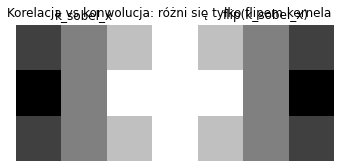

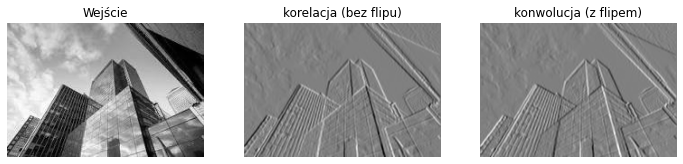

Średnia |różnica|: 0.49644890427589417


In [12]:
def corr2d_same(x, k, pad_mode="edge"):
    """Korelacja 2D: kernel bez odwracania (tak jest w większości bibliotek DL)."""
    return conv2d_same(x, k, pad_mode=pad_mode)

def conv2d_true_same(x, k, pad_mode="edge"):
    """"Prawdziwa" konwolucja 2D: kernel odwrócony w obu osiach."""
    k_flip = np.flip(k, axis=(0, 1))
    return conv2d_same(x, k_flip, pad_mode=pad_mode)

# Sobel X (klasyczny detektor krawędzi pionowych)
k_sobel_x = np.array([[-1, 0, 1],
                      [-2, 0, 2],
                      [-1, 0, 1]], dtype=np.float32)

# --- Różnica wizualna: kernel vs kernel odwrócony ---
k_flip = np.flip(k_sobel_x, axis=(0, 1))

print("Kernel (korelacja) k_sobel_x:\n", k_sobel_x)
print("\nKernel odwrócony (konwolucja) flip(k_sobel_x):\n", k_flip)

plt.figure(figsize=(6,2.5))
plt.subplot(1,2,1); plt.imshow(k_sobel_x, cmap="gray"); plt.title("k_sobel_x"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(k_flip, cmap="gray"); plt.title("flip(k_sobel_x)"); plt.axis("off")
plt.suptitle("Korelacja vs konwolucja: różni się tylko flipem kernela")
plt.show()

# --- Ten sam obraz, dwa sposoby liczenia ---
y_corr = corr2d_same(x, k_sobel_x)
y_conv = conv2d_true_same(x, k_sobel_x)

# Uczciwe porównanie: ta sama skala (dla filtrów znakowych to ważne)
m = max(np.abs(y_corr).max(), np.abs(y_conv).max())

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(x, cmap="gray", vmin=0, vmax=1); plt.title("Wejście"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(y_corr, cmap="gray", vmin=-m, vmax=m); plt.title("korelacja (bez flipu)"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(y_conv, cmap="gray", vmin=-m, vmax=m); plt.title("konwolucja (z flipem)"); plt.axis("off")
plt.show()

# Porównanie ilościowe
print("Średnia |różnica|:", float(np.mean(np.abs(y_corr - y_conv))))


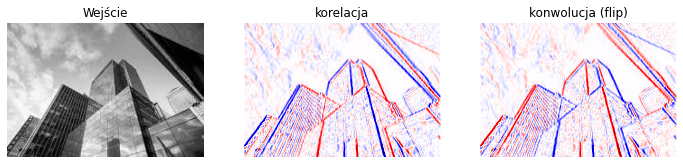

In [13]:
m = max(np.abs(y_corr).max(), np.abs(y_conv).max())

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(x, cmap="gray"); plt.title("Wejście"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(y_corr, cmap="seismic", vmin=-m, vmax=m); plt.title("korelacja"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(y_conv, cmap="seismic", vmin=-m, vmax=m); plt.title("konwolucja (flip)"); plt.axis("off")
plt.show()


# Pytania kontrolne – Ćwiczenia 2 i 3

---

## Ćwiczenie 2 – Padding (`valid` vs `same`)

### Pytania
1. Dlaczego konwolucja w trybie `valid` zmniejsza rozmiar obrazu?
2. Jaki jest cel stosowania paddingu?
3. Co oznacza tryb `same`?
4. Od czego zależy ilość paddingu w trybie `same`?
5. Czym różni się padding `zero` od paddingu `edge`?
6. W których miejscach obrazu różnice między `zero` i `edge` są największe?
7. Czy `same` zawsze daje „lepszy” wynik niż `valid`?

### Odpowiedzi (krótko)
1. Bo kernel nie może wyjść poza obraz i nie liczymy wartości na brzegach.
2. Aby zachować rozmiar obrazu lub kontrolować zachowanie na krawędziach.
3. To tryb, w którym rozmiar wyjścia jest taki sam jak wejścia.
4. Od rozmiaru kernela (np. dla 3×3 padding = 1).
5. `zero` dopisuje zera, `edge` powiela wartości z brzegu obrazu.
6. Na krawędziach obrazu.
7. Nie — `valid` i `same` rozwiązują różne problemy i mają różne zastosowania.

---

## Ćwiczenie 3 – Korelacja vs konwolucja

### Pytania
1. Czym różni się korelacja od matematycznej konwolucji?
2. Co oznacza „odwrócenie kernela”?
3. Jak wpływa odwrócenie kernela Sobela na wynik?
4. Czy miejsca wykrytych krawędzi zmieniają się po odwróceniu kernela?
5. Dlaczego w deep learning często liczy się korelację, a mówi „konwolucja”?
6. Czy różnica między korelacją a konwolucją ma znaczenie w CNN?

### Odpowiedzi (krótko)
1. Konwolucja odwraca kernel w obu osiach, korelacja nie.
2. Zmianę kolejności wag kernela w pionie i poziomie.
3. Zwykle zmienia znak odpowiedzi (dodatnie ↔ ujemne).
4. Nie — zmienia się znak lub orientacja, nie położenie krawędzi.
5. Bo kernel jest uczony i sieć może nauczyć się filtra o dowolnym znaku/orientacji.
6. Zwykle nie — różnica jest kompensowana przez uczenie wag.

---

## Jedno zdanie podsumowania
Padding kontroluje **rozmiar i zachowanie na brzegach**,  
a różnica między korelacją i konwolucją sprowadza się do **odwrócenia kernela**, które w CNN nie ma kluczowego znaczenia.


# Ćwiczenie 4 – Stride (krok konwolucji)

## Co oznacza stride?

W konwolucji **stride** określa, **co ile pikseli przesuwasz okno (kernel)** po obrazie.

- `stride = 1` → liczysz wynik w każdym możliwym położeniu okna  
- `stride = 2` → przeskakujesz co drugi piksel → mapa cech jest ~2× mniejsza w każdym wymiarze

![stride_diagram](images/stride_diagram.png)

To jest forma **downsamplingu** (zmniejszania rozdzielczości), która:
- redukuje obliczenia,
- zwiększa “pole widzenia” kolejnych warstw,
- ale usuwa część szczegółów.

---

## Ściąga: rozmiar wyjścia przy stride

Dla `valid` (bez paddingu, bez dilation):

$$
H_{out} = \left\lfloor \frac{H-k_H}{s} \right\rfloor + 1,\qquad
W_{out} = \left\lfloor \frac{W-k_W}{s} \right\rfloor + 1.
$$

---

## Pytania kontrolne

1. Co się stanie z mapą cech, gdy zwiększysz stride z 1 na 2?  
2. Czy stride=2 działa bardziej jak “subsampling” czy jak “filtracja”?  
3. Jak stride wpływa na liczbę obliczeń?



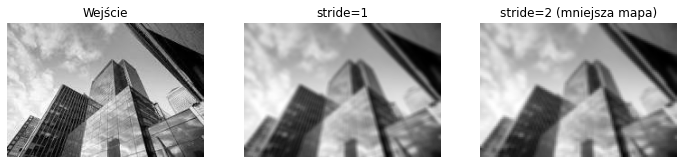

In [14]:
def conv2d_stride(x, k, stride=2, pad_mode="edge"):
    y_same = conv2d_same(x, k, pad_mode=pad_mode)
    return y_same[::stride, ::stride]

k_blur = np.ones((5,5), dtype=np.float32) / 25.0
y_s1 = conv2d_stride(x, k_blur, stride=1)
y_s2 = conv2d_stride(x, k_blur, stride=2)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(x, cmap="gray"); plt.title("Wejście"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(y_s1, cmap="gray"); plt.title("stride=1"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(y_s2, cmap="gray"); plt.title("stride=2 (mniejsza mapa)"); plt.axis("off")
plt.show()


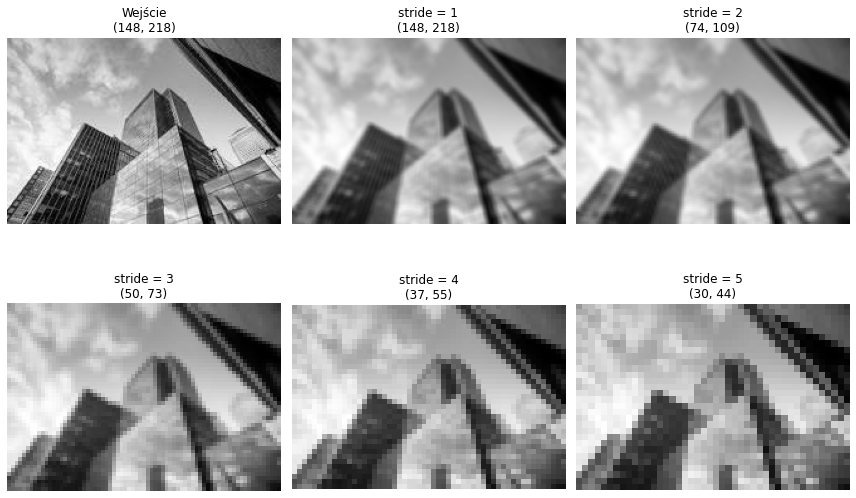

In [15]:
strides = [1, 2, 3, 4, 5]
ys = [conv2d_stride(x, k_blur, stride=s) for s in strides]

n_cols = 3   # ile kolumn chcesz
n_rows = 2

plt.figure(figsize=(4 * n_cols, 4 * n_rows))

# --- Wejście ---
plt.subplot(n_rows, n_cols, 1)
plt.imshow(x, cmap="gray")
plt.title("Wejście\n" + str(x.shape))
plt.axis("off")

# --- Kolejne stride ---
for idx, (s, y) in enumerate(zip(strides, ys), start=2):
    plt.subplot(n_rows, n_cols, idx)
    plt.imshow(y, cmap="gray")
    plt.title(f"stride = {s}\n{y.shape}")
    plt.axis("off")

plt.tight_layout()
plt.show()


## Jak liczymy rozmiar obrazu przy stride?

Przy konwolucji (lub downsamplingu) ze `stride > 1` **nie dzielimy rozmiaru obrazu wprost przez stride**.  
Zamiast tego liczymy **ile pozycji okna faktycznie się zmieści**.

---

### Przykład 1: „czyste” dzielenie
Jeśli mamy obraz o rozmiarze:
- `H = 148`
- `stride = 3`

to pozycje próbkowania są:
(148 - 1) // 3 + 1 = 147 // 3 + 1 = 49 + 1 = 50

## Wnioski
- `stride=1` daje mapę cech o podobnej rozdzielczości jak wejście (`same`).
- `stride=2` zmniejsza rozdzielczość, bo próbkujemy wynik rzadziej (mniej punktów).
- Downsampling powoduje utratę drobnych detali; dlatego często stosuje się wcześniej wygładzanie (np. filtr uśredniający), aby ograniczyć aliasing.


# Ćwiczenie 5 – Dylatacja (dilation)

## Opis
Dylatacja (ang. *dilation*) to sposób zwiększania **pola widzenia kernela** bez zwiększania liczby jego parametrów.  
Osiąga się to przez „rozrzedzenie” kernela – wstawienie zer pomiędzy jego elementy.

Dzięki dylatacji pojedyncza konwolucja może reagować na **bardziej odległe piksele**, co zwiększa tzw. **receptive field** neuronu.

---

## Zadanie
1. Zastosuj filtr bez dylatacji (`dilation = 1`).
2. Zastosuj ten sam filtr z dylatacją `dilation = 2`.
3. Porównaj wyniki dla obrazu `cross`.

---

## Cel ćwiczenia
- Zrozumienie pojęcia **receptive field**.
- Zobaczenie, jak można wykrywać większe struktury **bez zwiększania liczby wag**.
- Intuicja skali w CNN.

---

## Oczekiwany wynik
- Przy `dilation = 1` filtr reaguje na lokalne struktury.
- Przy `dilation = 2` filtr „widzi” większy obszar obrazu.
- Większe struktury są wyraźniejsze przy większej dylatacji.


# Ćwiczenie 5 – Dylatacja (dilation)
## Interpretacja wyników (na przykładzie Laplasjanu)

### Przypomnienie: jaki kernel tu stosujesz?

W tym ćwiczeniu używamy **dyskretnego Laplasjanu** (4‑sąsiedztwo):

$$
K_{lap}=
\begin{bmatrix}
0 & 1 & 0\\
1 & -4 & 1\\
0 & 1 & 0
\end{bmatrix}
$$

Intuicyjnie działa jak **druga pochodna**: mierzy “krzywiznę” jasności.

Wprost (dla piksela $(i,j)$):

$$
y_{i,j} = -4\,x_{i,j} + x_{i-1,j} + x_{i+1,j} + x_{i,j-1} + x_{i,j+1}.
$$

- w obszarze jednorodnym: sąsiedzi $pprox x_{i,j}$ → wynik bliski 0  
- na krawędzi: sąsiedzi bardzo różni → wynik o dużej wartości bezwzględnej

---

### Dylatacja = zmiana skali analizy

Dylatacja nie zmienia liczby wag kernela, ale zwiększa **odległość między aktywnymi wagami**.  
To zmienia skalę tego, “na co patrzy” filtr.

Efektywny rozmiar kernela (dla rozmiaru $k$ i dylatacji $d$):

$$
k^{eff} = d\,(k-1)+1.
$$

- mała dylatacja → detale, lokalne krawędzie  
- średnia dylatacja → większe struktury  
- bardzo duża dylatacja → filtr porównuje bardzo odległe piksele (mogą pojawiać się artefakty)

---

### Pytanie kontrolne

Dlaczego przy bardzo dużej dylatacji filtr przestaje “łapać” lokalne krawędzie?



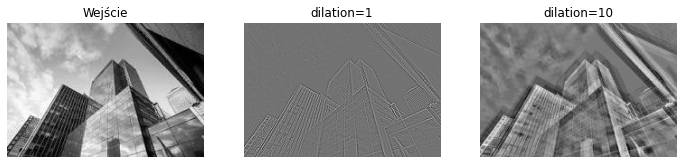

In [16]:
def dilate_kernel(k, d):
    # wstawia zera między elementy kernela (d=1 -> bez zmian)
    if d == 1:
        return k
    kh, kw = k.shape
    out = np.zeros((kh + (kh-1)*(d-1), kw + (kw-1)*(d-1)), dtype=np.float32)
    out[::d, ::d] = k
    return out

k = np.array([[0,1,0],
              [1,-4,1],
              [0,1,0]], dtype=np.float32)  # prosty filtr laplasjanu
d1=10
k_d2 = dilate_kernel(k, d=d1)
y1 = conv2d_same(x, k)
y2 = conv2d_same(x, k_d2)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(x, cmap="gray"); plt.title("Wejście"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(y1, cmap="gray"); plt.title("dilation=1"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(y2, cmap="gray"); plt.title(f"dilation={d1}"); plt.axis("off")
plt.show()


## (Dygresja) Laplasjan: intuicja

To dyskretna wersja operatora Laplace’a, który jest aproksymacją **drugiej pochodnej** jasności obrazu.

---

## 1) Dlaczego w obszarach jednorodnych wynik jest bliski zeru?

W jednolitym obszarze wszystkie piksele mają (prawie) tę samą wartość.
Jeśli środek i jego czterej sąsiedzi są podobni, to „plusy” i „minus” w kernelu się znoszą.

### Przykład (obszar jednorodny)
Załóżmy, że:
- środek = 100
- góra, dół, lewo, prawo = 100

Wynik działania kernela:

$$
(100+100+100+100) - 4\cdot 100 = 400 - 400 = 0
$$

**Interpretacja:**  
Operator Laplace’a mierzy lokalną „stałość” (brak krzywizny).  
Jeśli nic się nie zmienia w otoczeniu piksela, wynik jest ~0.

---

## 2) Dlaczego wykrywa krawędzie i struktury?

Na krawędzi jasność zmienia się gwałtownie. Wtedy sąsiedzi znacząco różnią się od środka,
więc suma sąsiadów nie równoważy składnika $-4 \cdot \text{środek}$ i pojawia się duża wartość dodatnia lub ujemna.

### Przykład (krawędź)
Załóżmy:
- lewo = 0
- środek = 100
- prawo = 255
- góra = 100
- dół = 100

Wynik:

$$
(100 + 100 + 0 + 255) - 4\cdot 100 = 455 - 400 = 55
$$

**Interpretacja:**  
Duża wartość oznacza, że w sąsiedztwie piksela dzieje się „coś ważnego” (krawędź / struktura).

---

## 3) Związek z drugą pochodną (krzywizną jasności)

- **Pierwsza pochodna** mierzy „nachylenie” (zmianę) – typowo kojarzona z gradientem i filtrami Sobela.
- **Druga pochodna** mierzy „tempo zmiany nachylenia”, czyli **krzywiznę**.

Dlatego Laplasjan:
- reaguje nie tylko na same krawędzie,
- ale też mocno na **narożniki, cienkie linie, miejsca gwałtownej zmiany struktury**.

**Intuicja:**  
Tam, gdzie jasność „zakrzywia się” najszybciej (ostre narożniki, cienkie detale),
odpowiedź Laplasjanu ma największą wartość (dodatnią lub ujemną).

---

## 4) Uwaga praktyczna (wizualizacja)
Laplasjan daje wartości dodatnie i ujemne.  
Dlatego często wizualizuje się:
- **znak** (np. kolormapą typu `seismic` z zakresem symetrycznym),
albo
- **moc odpowiedzi**: $|y|$ (wartość bezwzględna), która pokazuje „siłę krawędzi” bez rozróżniania znaku.

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def show_dilations(
    x, k, conv_fn, dilate_fn,
    ds=range(1, 11),
    pad_mode="edge",
    show="abs",          # "abs" albo "signed"
    cmap_abs="gray",
    cmap_signed="seismic",
    ncols=5,
    figsize=(16, 7)
):
    """
    Rysuje wyniki konwolucji dla wielu dylatacji.
    
    x        : obraz 2D
    k        : kernel bazowy (np. Laplasjan 3x3)
    conv_fn  : funkcja konwolucji 'same', np. conv2d_same(x, k, pad_mode=...)
    dilate_fn: funkcja dylatacji kernela, np. dilate_kernel(k, d)
    ds       : iterowalne wartości dilation (domyślnie 1..10)
    show     : 'abs' (moc odpowiedzi) albo 'signed' (znak + skala symetryczna)
    """
    ds = list(ds)
    ys = []
    for d in ds:
        kd = dilate_fn(k, d=d)
        y = conv_fn(x, kd, pad_mode=pad_mode)
        ys.append(y)

    n = len(ds)
    nrows = int(np.ceil(n / ncols))

    plt.figure(figsize=figsize)

    if show == "signed":
        m = max(float(np.abs(y).max()) for y in ys) if ys else 1.0

    for i, (d, y) in enumerate(zip(ds, ys), start=1):
        plt.subplot(nrows, ncols, i)

        if show == "abs":
            plt.imshow(np.abs(y), cmap=cmap_abs)
            plt.title(f"d={d}  |y|")
        elif show == "signed":
            plt.imshow(y, cmap=cmap_signed, vmin=-m, vmax=m)
            plt.title(f"d={d}  signed")
        else:
            raise ValueError("show must be 'abs' or 'signed'")

        plt.axis("off")

    plt.tight_layout()
    plt.show()


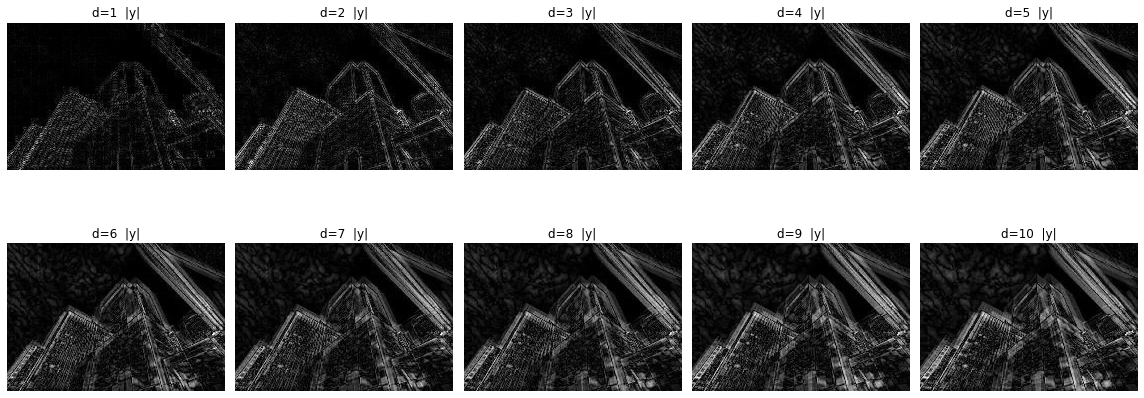

In [18]:
k_lap = np.array([[0,1,0],
                  [1,-4,1],
                  [0,1,0]], dtype=np.float32)

show_dilations(x, k_lap, conv2d_same, dilate_kernel, ds=range(1, 11), show="abs", ncols=5)


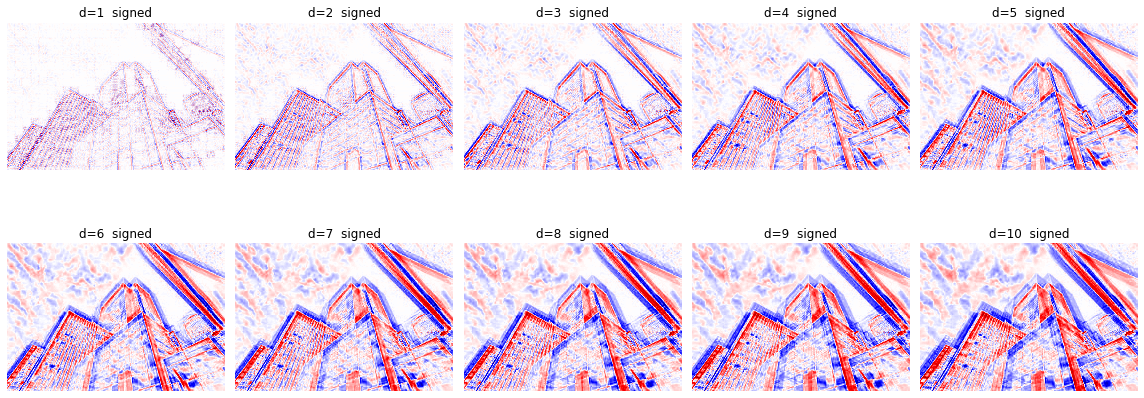

In [19]:
show_dilations(x, k_lap, conv2d_same, dilate_kernel, ds=range(1, 11), show="signed", ncols=5)



---

Jeśli chcesz, **kolejnym naturalnym domknięciem całej serii** może być:
- **Ćwiczenie 6 – Pooling (max vs average)** jako kontrast do stride i dylatacji  
- albo **Ćwiczenie 6 – Receptive field całej sieci (liczony warstwa po warstwie)**


### Dodatkowy eksperyment (opcjonalnie)

Spróbuj uruchomić serię dylatacji (np. `d=1..10`) i porównać, jak zmienia się **skala** struktur, na które reaguje filtr.  
To jest intuicyjny sposób, żeby zrozumieć *receptive field* bez liczenia wzorów.


---

# Ćwiczenie 6 – Konwolucja RGB

### Opis
Obraz kolorowy to trzy kanały danych.

### Zadanie
1. Zastosuj ten sam kernel do R, G i B.
2. Połącz wyniki w obraz RGB.

### Cel
- Zrozumienie struktury danych wejściowych CNN.
- Przygotowanie pod filtry 3D.

### Oczekiwany wynik
- Filtr działa niezależnie na kanałach.
- Efekt zależny od koloru.



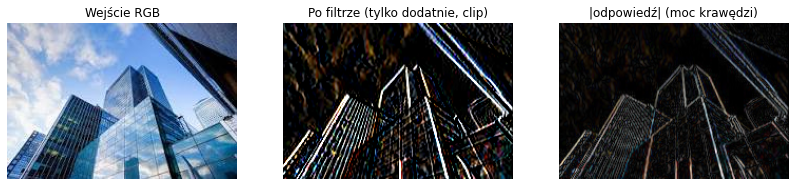

In [20]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img_rgb = Image.open("images/obrazek.jpg").convert("RGB")
X = np.array(img_rgb, dtype=np.float32) / 255.0  # HxWx3

k = np.array([[ 1, 0,-1],
              [ 2, 0,-2],
              [ 1, 0,-1]], dtype=np.float32)  # Sobel (pionowe krawędzie)

Y = np.zeros_like(X)
for c in range(3):
    Y[..., c] = conv2d_same(X[..., c], k, pad_mode="edge")

# Dwie wizualizacje: signed i magnitude
Y_abs = np.abs(Y)
Y_abs = Y_abs / (Y_abs.max() + 1e-8)  # normalizacja tylko do podglądu

plt.figure(figsize=(14,4))
plt.subplot(1,3,1); plt.imshow(X);      plt.title("Wejście RGB"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(np.clip(Y, 0, 1)); plt.title("Po filtrze (tylko dodatnie, clip)"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(Y_abs);  plt.title("|odpowiedź| (moc krawędzi)"); plt.axis("off")
plt.show()


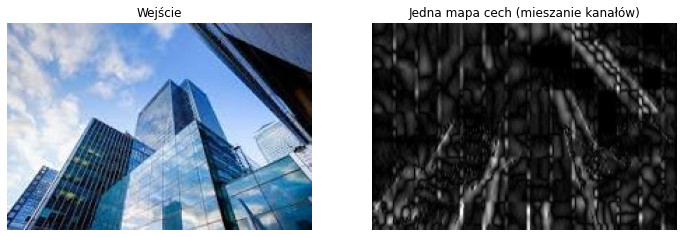

In [21]:
kR = k
kG = 0.0 * k
kB = -k

y3d = conv2d_same(X[...,0], kR, pad_mode="edge") \
    + conv2d_same(X[...,1], kG, pad_mode="edge") \
    + conv2d_same(X[...,2], kB, pad_mode="edge")

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(X); plt.title("Wejście"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(np.abs(y3d), cmap="gray"); plt.title("Jedna mapa cech (mieszanie kanałów)"); plt.axis("off")
plt.axis("off")
plt.show()


## Interpretacja wyniku: mieszanie kanałów RGB

W tym eksperymencie zastosowaliśmy **różne wagi kernela do kanałów R, G i B**, a następnie **zsumowaliśmy ich odpowiedzi do jednej mapy cech**.

Wynik nie jest już obrazem RGB, lecz **pojedynczą mapą cech** (2D), która koduje informację o strukturze obrazu zależnie od koloru.

---

### Co dokładnie się stało?

Dla obrazu RGB:
X ∈ ℝ^{H×W×3}


zastosowaliśmy:
- osobny kernel do kanału R,
- osobny (lub zerowy) kernel do kanału G,
- osobny kernel do kanału B,

a następnie obliczyliśmy:


y = conv(R, k_R) + conv(G, k_G) + conv(B, k_B)


To jest **dokładnie mechanizm działania pojedynczego filtra w warstwie CNN**.

---

### Dlaczego wynik wygląda „teksturalnie” i nienaturalnie?

- Filtr reaguje na **różnice pomiędzy kanałami**, a nie na samą jasność.
- Obszary, gdzie kolor zmienia się gwałtownie (np. odbicia, szkło, niebo vs budynek),
  dają silną odpowiedź.
- Obraz wynikowy pokazuje **kontrast kolorystyczny jako strukturę**.

To nie jest „zepsuty obraz”, tylko **abstrakcyjna reprezentacja cech**.

---

### Kluczowa intuicja pod CNN

> Warstwy konwolucyjne **nie produkują obrazów do oglądania**,  
> tylko **mapy cech**, które kodują różne aspekty danych.

W CNN:
- jeden filtr → jedna mapa cech,
- wiele filtrów → wiele map cech,
- kolejne warstwy uczą się coraz bardziej abstrakcyjnych reprezentacji.

---

### Dlaczego to jest ważniejsze niż filtrowanie kanał po kanale?

Filtrowanie kanałowe (R, G, B osobno):
- nie miesza informacji o kolorze,
- zachowuje strukturę obrazu.

Mieszanie kanałów:
- pozwala wykrywać **kontrasty barwne**,
- umożliwia uczenie się cech typu:
  - „jasny niebieski obok ciemnego”,
  - „szkło vs stal”,
  - „niebo vs budynek”.

To jest **główna siła CNN na obrazach kolorowych**.

---

### Jedno zdanie podsumowania
> Mieszanie kanałów pozwala sieci wykrywać cechy zależne od koloru, a nie tylko od jasności.

---

### Pytanie kontrolne
Dlaczego wynik mieszania kanałów nie przypomina obrazu RGB?

**Odpowiedź:**  
Bo jest to pojedyncza mapa cech powstała z kombinacji kanałów, a nie obraz przeznaczony do wizualizacji.

To jest **dokładnie mechanizm działania pojedynczego filtra w warstwie CNN**.

---

### Dlaczego wynik wygląda „teksturalnie” i nienaturalnie?

- Filtr reaguje na **różnice pomiędzy kanałami**, a nie na samą jasność.
- Obszary, gdzie kolor zmienia się gwałtownie (np. odbicia, szkło, niebo vs budynek),
  dają silną odpowiedź.
- Obraz wynikowy pokazuje **kontrast kolorystyczny jako strukturę**.

To nie jest „zepsuty obraz”, tylko **abstrakcyjna reprezentacja cech**.

---

### Kluczowa intuicja pod CNN

> Warstwy konwolucyjne **nie produkują obrazów do oglądania**,  
> tylko **mapy cech**, które kodują różne aspekty danych.

W CNN:
- jeden filtr → jedna mapa cech,
- wiele filtrów → wiele map cech,
- kolejne warstwy uczą się coraz bardziej abstrakcyjnych reprezentacji.

---

### Dlaczego to jest ważniejsze niż filtrowanie kanał po kanale?

Filtrowanie kanałowe (R, G, B osobno):
- nie miesza informacji o kolorze,
- zachowuje strukturę obrazu.

Mieszanie kanałów:
- pozwala wykrywać **kontrasty barwne**,
- umożliwia uczenie się cech typu:
  - „jasny niebieski obok ciemnego”,
  - „szkło vs stal”,
  - „niebo vs budynek”.

To jest **główna siła CNN na obrazach kolorowych**.

---

### Jedno zdanie podsumowania
> Mieszanie kanałów pozwala sieci wykrywać cechy zależne od koloru, a nie tylko od jasności.

---

### Pytanie kontrolne
Dlaczego wynik mieszania kanałów nie przypomina obrazu RGB?

**Odpowiedź:**  
Bo jest to pojedyncza mapa cech powstała z kombinacji kanałów, a nie obraz przeznaczony do wizualizacji.



### Ile parametrów ma `Conv2d`?

To jest świetny moment na **najważniejszą intuicję CNN**: *dużo mniej parametrów niż warstwa gęsta*.

Jeśli masz:
- $C_{in}$ kanałów wejściowych,
- $C_{out}$ filtrów (kanałów wyjściowych),
- kernel $k_H \times k_W$,

to liczba wag (bez biasu) wynosi:

$$
\#W = C_{out}\cdot C_{in}\cdot k_H\cdot k_W.
$$

Jeśli bias jest włączony (zwykle tak), to dodatkowo:

$$
\#b = C_{out}.
$$

**Przykład:** wejście RGB ($C_{in}=3$), 16 filtrów 3×3:  
$\#W = 16\cdot3\cdot3\cdot3 = 432$ (+16 biasów).

Porównaj to z warstwą gęstą (`Linear`) na obrazie 32×32×3:  
wejście ma $3072$ liczb, więc sama macierz wag do 16 wyjść ma $3072\cdot16=49152$ wag.  
To różnica rzędu **100×** już na bardzo małych obrazkach.

**Dygresja dydaktyczna:**  
CNN działa dobrze, bo zakłada, że *ten sam filtr jest sensowny w wielu miejscach obrazu* (parametry są współdzielone w przestrzeni).


# Ćwiczenie 7 – Mapy cech (feature maps)

W jednej warstwie konwolucyjnej **ten sam obraz wejściowy** przechodzi przez **wiele filtrów**.  
Każdy filtr tworzy **osobną mapę cech** (*feature map*).

> Jedno wejście → wiele filtrów → wiele map cech  
> To jest dokładnie to, co robi pojedyncza warstwa `Conv2d`.

---

## Zadanie

1. Zdefiniuj kilka prostych, ręcznie dobranych kerneli (np. blur, sharpen, Sobel X/Y, Laplacian).
2. Zastosuj je do tego samego obrazu wejściowego.
3. Wyświetl wszystkie mapy cech obok siebie.

---

## Na co patrzeć?

- **Sobel X/Y**: reagują na krawędzie w konkretnym kierunku.  
- **Laplacian**: daje wartości dodatnie i ujemne → czasem lepiej oglądać też $|\cdot|$.  
- **Blur / Sharpen**: pokazują filtrację niskich / wysokich częstotliwości.

---

## Pytania kontrolne

1. Dlaczego Sobel X i Sobel Y dają różne mapy?  
2. Czy mapa cech to “obraz”? Co jest na osi wartości?  
3. Co by się stało, gdybyś miał 64 filtry zamiast 5?



In [22]:
kernels = {
    "Blur": np.ones((3,3), dtype=np.float32) / 9.0,

    "Sharpen": np.array([[0,-1,0],
                          [-1,5,-1],
                          [0,-1,0]], dtype=np.float32),

    "Sobel X": np.array([[-1,0,1],
                          [-2,0,2],
                          [-1,0,1]], dtype=np.float32),

    "Sobel Y": np.array([[-1,-2,-1],
                          [ 0, 0, 0],
                          [ 1, 2, 1]], dtype=np.float32),

    "Laplacian": np.array([[0,1,0],
                            [1,-4,1],
                            [0,1,0]], dtype=np.float32),
}


In [23]:
feature_maps = {}

for name, k in kernels.items():
    feature_maps[name] = conv2d_same(x, k, pad_mode="edge")


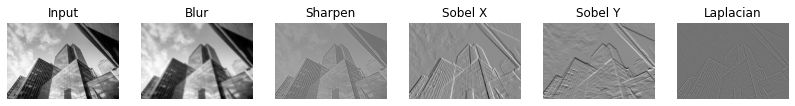

In [24]:
n = len(feature_maps) + 1
plt.figure(figsize=(14, 3))

plt.subplot(1, n, 1)
plt.imshow(x, cmap="gray")
plt.title("Input")
plt.axis("off")

for i, (name, fmap) in enumerate(feature_maps.items(), start=2):
    plt.subplot(1, n, i)
    plt.imshow(fmap, cmap="gray")
    plt.title(name)
    plt.axis("off")

plt.show()


## Naturalna sekwencja (blok CNN)

W praktyce bardzo często spotkasz powtarzający się schemat:

> **Conv → ReLU → Pool**

- **Conv** tworzy mapy cech (wykrywa lokalne wzorce).  
- **ReLU** dodaje nieliniowość (i “wygasza” odpowiedzi ujemne).  
- **Pool** zmniejsza rozdzielczość (downsampling) i upraszcza reprezentację.

W ćwiczeniu 7 zrobiłeś samą konwolucję (Conv).  
Teraz dokładamy ReLU i Pool — i zobaczysz, jak zmieniają się mapy cech.



# Ćwiczenie 8 – ReLU i nieliniowość

Do tej pory wszystkie operacje, które robiłeś (konwolucja, suma, różnice) były **liniowe**.  
Gdybyś ułożył wiele takich warstw jedna po drugiej, nadal dostałbyś “jedną dużą operację liniową”.

Dlatego w CNN potrzebujesz **nieliniowości**.

Najczęściej używana jest ReLU (*Rectified Linear Unit*):

$$
\mathrm{ReLU}(x)=\max(0,x).
$$

- wartości ujemne → zamienia na 0  
- wartości dodatnie → zostawia bez zmian

![relu_diagram](images/relu_diagram.png)

---

## Zadanie

1. Zastosuj ReLU do map cech z ćwiczenia 7.  
2. Porównaj mapy cech **przed i po ReLU**.  
3. Zobacz, jaki procent wartości staje się zerami (to jest typowy efekt ReLU).



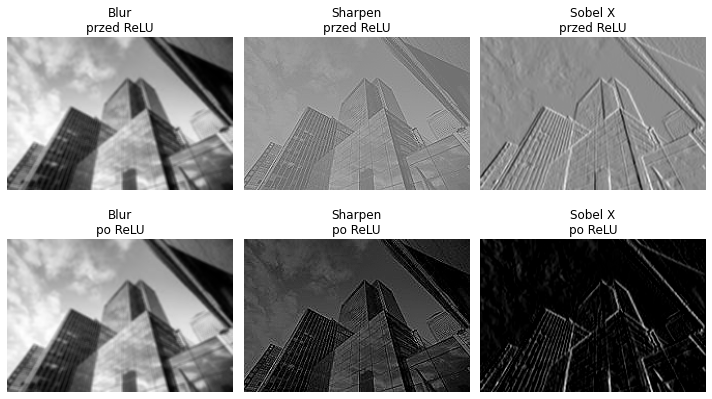

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def relu(x):
    return np.maximum(0, x)
relu_maps = {name: relu(fm) for name, fm in feature_maps.items()}

# wizualizacja: przed i po ReLU dla 2–3 filtrów
names = list(feature_maps.keys())[:3]

plt.figure(figsize=(10, 6))
for i, name in enumerate(names):
    plt.subplot(2, len(names), i+1)
    plt.imshow(feature_maps[name], cmap="gray")
    plt.title(f"{name}\nprzed ReLU")
    plt.axis("off")

    plt.subplot(2, len(names), len(names)+i+1)
    plt.imshow(relu_maps[name], cmap="gray")
    plt.title(f"{name}\npo ReLU")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [26]:
for name in names:
    fm = feature_maps[name]
    rm = relu_maps[name]
    print(f"{name:>10} | min/max przed: {fm.min(): .3f}/{fm.max(): .3f} | po: {rm.min(): .3f}/{rm.max(): .3f} | %zer: {(rm==0).mean()*100: .1f}%")


      Blur | min/max przed:  0.000/ 0.983 | po:  0.000/ 0.983 | %zer:  0.0%
   Sharpen | min/max przed: -2.290/ 2.855 | po:  0.000/ 2.855 | %zer:  10.2%
   Sobel X | min/max przed: -3.204/ 2.596 | po:  0.000/ 2.596 | %zer:  53.2%


# Ćwiczenie 9 – Pooling i downsampling

Pooling to kolejny “klocek” w typowej sekwencji CNN:

> Conv → ReLU → **Pool**

Najczęściej spotkasz **max‑pooling 2×2 ze stride=2**, czyli:
- bierzesz okno 2×2,
- wybierasz maksimum,
- przesuwasz się co 2 (downsampling).

![maxpool_diagram](images/maxpool_diagram.png)

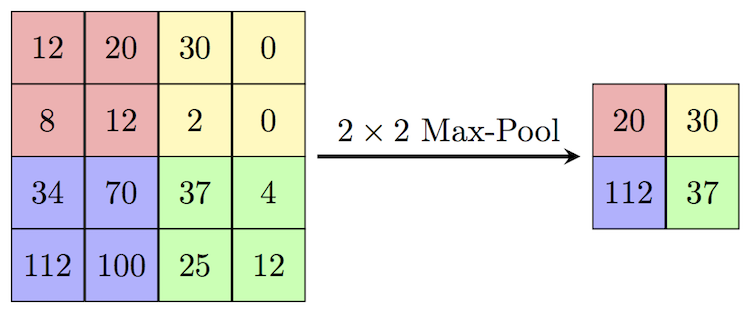

**Po co to robimy?**
- zmniejszasz rozmiar map cech (mniej obliczeń dalej),
- zyskujesz pewną odporność na małe przesunięcia (invariance),
- zwiększasz “pole widzenia” kolejnych warstw.

---

## Zadanie

Zrób pooling (avg i max) na wybranej mapie cech i porównaj:
- kształty (`shape`),
- wygląd mapy (co zostaje po downsamplingu).



In [27]:
def avg_pool2d(x, pool=2):
    H, W = x.shape
    out = np.zeros((H//pool, W//pool), dtype=x.dtype)

    for i in range(0, H, pool):
        for j in range(0, W, pool):
            out[i//pool, j//pool] = np.mean(x[i:i+pool, j:j+pool])
    return out


def max_pool2d(x, pool=2):
    H, W = x.shape
    out = np.zeros((H//pool, W//pool), dtype=x.dtype)

    for i in range(0, H, pool):
        for j in range(0, W, pool):
            out[i//pool, j//pool] = np.max(x[i:i+pool, j:j+pool])
    return out


Mapa 'Blur': przed=(148, 218), avg=(74, 109), max=(74, 109)


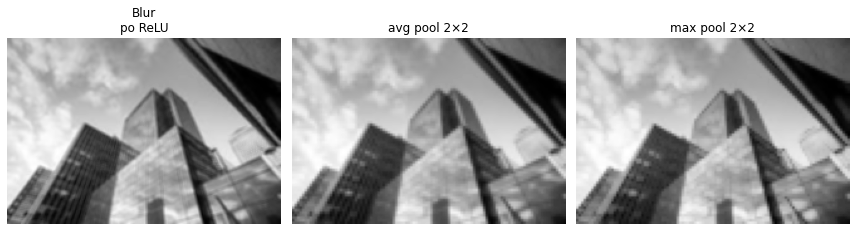

In [28]:
# --- Pooling (avg / max) na mapach cech po ReLU ---

# Wybierz jedną mapę, na której pooling jest czytelny
name = list(relu_maps.keys())[0]  # np. "Blur" / "Sharpen" / "Sobel X" ...
a = relu_maps[name]

avg = avg_pool2d(a, pool=2)
mx  = max_pool2d(a, pool=2)

print(f"Mapa '{name}': przed={a.shape}, avg={avg.shape}, max={mx.shape}")

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(a, cmap="gray");   plt.title(f"{name}\npo ReLU"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(avg, cmap="gray"); plt.title("avg pool 2×2"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(mx, cmap="gray");  plt.title("max pool 2×2"); plt.axis("off")
plt.tight_layout()
plt.show()


### Uwaga o kształtach tensorów (bardzo ważne)

Własne implementacje w numpy często używają:
- obraz 2D: $(H, W)$,
- obraz RGB: $(H, W, C)$ — kanały na końcu (*HWC*).

W PyTorch standardem jest:
- pojedynczy obraz: $(C, H, W)$ (*CHW*),
- batch obrazów: $(N, C, H, W)$ (*NCHW*).

Dlatego w tym ćwiczeniu świadomie przechodzimy na $(C, H, W)$, żeby:
1) zrozumieć co robi `Conv2d`,  
2) nie gubić się w tym, czy „kanały są z przodu czy z tyłu”.


## 9.1. Zbuduj „tensor” wejściowy drugiej warstwy: (C, H, W)

W ćwiczeniu 7 dostałeś kilka map cech (po ReLU).  
Teraz traktujesz je jako **kanały wejściowe** kolejnej warstwy.

W PyTorch to byłby tensor o kształcie `(C, H, W)`.



In [29]:
# 9.1 — Tensor wejściowy dla 2. warstwy (CHW)

# Mamy słownik relu_maps: kilka map cech po 1. warstwie (każda to macierz H×W).
# Teraz składamy je w jeden tensor (C, H, W), gdzie:
# - C = liczba kanałów (= liczba map cech z warstwy 1),
# - H, W = rozdzielczość map.
#
# To dokładnie odpowiada temu, co w PyTorch ma kształt (C, H, W) dla pojedynczego obrazu.

ch_names = list(relu_maps.keys())                 # stała kolejność kanałów
X1 = np.stack([relu_maps[n] for n in ch_names], axis=0)  # (C, H, W)

print("Kanały (C):", ch_names)
print("X1 shape (C,H,W):", X1.shape)


Kanały (C): ['Blur', 'Sharpen', 'Sobel X', 'Sobel Y', 'Laplacian']
X1 shape (C,H,W): (5, 148, 218)


## 9.2. Konwolucja wielokanałowa: suma po kanałach

W drugiej warstwie kernel nie jest już 2D.  
Ma kształt:

- wejście: $(C, H, W)$  
- filtr: $(C, k_H, k_W)$

I wynik jednego filtra to:

$$
y = \sum_{c=1}^{C} \mathrm{conv2d}(X_c, K_c)
$$

Czyli **sumujesz wkład z każdego kanału**.



In [30]:
def conv2d_multi_in_same(X, K, pad_mode="edge"):
    """Konwolucja (korelacja) wielokanałowa dla jednego filtra.

    Parametry:
    - X: tensor wejściowy (C, H, W)  — C kanałów (np. mapy cech z poprzedniej warstwy)
    - K: filtr (C, kH, kW)           — jeden filtr ma osobny kernel dla każdego kanału
    - pad_mode: jak robimy padding w conv2d_same

    Zwraca:
    - y: (H, W) — jedna mapa cech (wynik działania *jednego* filtra)

    Kluczowa idea CNN:
    - filtr “patrzy” na wszystkie kanały,
    - liczymy konwolucję osobno w każdym kanale,
    - a potem SUMUJEMY po kanałach.
    """
    C, H, W = X.shape
    out = np.zeros((H, W), dtype=np.float32)

    for c in range(C):
        out += conv2d_same(X[c], K[c], pad_mode=pad_mode)

    return out


## 9.3. Druga warstwa: wiele filtrów → wiele map

Jeśli masz **F filtrów** w warstwie 2, to dostaniesz **F map cech** na wyjściu.

To jest dokładnie analogia do 1. warstwy:
- 1 wejście → wiele filtrów → wiele map.

Różnica jest taka, że teraz wejście ma już wiele kanałów.



In [31]:
# 9.3 — Druga warstwa: wiele filtrów → wiele map cech

# W prawdziwej sieci CNN K2 byłoby trenowane (uczone z danych).
# Tutaj generujemy K2 losowo, żeby zrozumieć *mechanikę*:
# - jeden filtr ma kształt (C, kH, kW),
# - jeśli mamy F filtrów, to mamy tensor (F, C, kH, kW),
# - wynik to F map cech (każda (H, W)).

np.random.seed(0)

C, H, W = X1.shape
F = 4          # liczba filtrów w drugiej warstwie (ile nowych map cech)
kH = kW = 3

K2 = np.random.randn(F, C, kH, kW).astype(np.float32) * 0.5  # (F, C, kH, kW)

feature2 = {}
for f in range(F):
    fm2 = conv2d_multi_in_same(X1, K2[f], pad_mode="edge")   # (H, W)
    feature2[f"layer2_f{f}"] = relu(fm2)                      # + ReLU

print("Liczba map w warstwie 2:", len(feature2))
print("Jedna mapa shape:", next(iter(feature2.values())).shape)


Liczba map w warstwie 2: 4
Jedna mapa shape: (148, 218)


## 9.4. Wizualizacja warstwy 2

W tej sekcji tylko wizualizujesz mapy cech z warstwy 2.

Uwaga dydaktyczna:
- ponieważ filtry są tutaj losowe (nieuczone), mapy mogą wyglądać “losowo”,
- w prawdziwej sieci, po treningu, warstwy 2+ uczą się bardziej złożonych wzorców (fragmenty kształtów, tekstury, części obiektów).



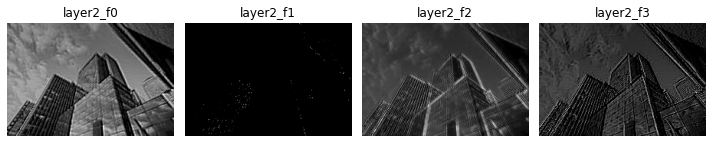

In [32]:
plt.figure(figsize=(10, 3))
for i, (name, fm) in enumerate(feature2.items()):
    plt.subplot(1, len(feature2), i+1)
    plt.imshow(fm, cmap="gray")
    plt.title(name)
    plt.axis("off")
plt.tight_layout()
plt.show()


# Ćwiczenie 10 – Od map cech do wektora (flatten)

Tu robimy dydaktycznie: CNN → liczby → klasyfikator/regresor.

##  10.1. Pooling (opcjonalnie, ale warto)

Masz już avg_pool2d i max_pool2d w notebooku. Użyj np. maxpool:

In [33]:
pooled2 = {name: max_pool2d(fm, pool=2) for name, fm in feature2.items()}
print("Po poolingu shape:", next(iter(pooled2.values())).shape)


Po poolingu shape: (74, 109)


##  10.2. Flatten: stos map → 1 wektor

In [34]:
Z = np.stack(list(pooled2.values()), axis=0)   # (F, Hp, Wp)
v = Z.reshape(-1)                               # (F*Hp*Wp,)

print("Z shape:", Z.shape)
print("v length:", len(v))


Z shape: (4, 74, 109)
v length: 32264


## 10.3 to po prostu lista liczb 

In [35]:
print("Pierwsze 20 elementów wektora:", np.round(v[:20], 3))


Pierwsze 20 elementów wektora: [3.368 3.045 4.781 4.657 4.262 4.272 4.225 5.014 4.918 5.153 5.009 4.831
 4.701 4.395 4.304 3.971 3.511 4.131 4.752 4.318]


# Ćwiczenie 11 – Regresja vs klasyfikacja (dwie „główki” na tym samym wektorze) 

## Ćwiczenie 11 – Regresja vs klasyfikacja (ostatnia warstwa = „główka”)

Do tego momentu robiłeś **feature extractor**:

> obraz → konwolucje → ReLU → pooling → flatten → **wektor cech** $v$

Teraz dokładamy **ostatni mały fragment sieci**, który “odpowiada na pytanie”.
Ten fragment często nazywa się:

- **head** / **główka**,
- a wcześniejszą część: **backbone** / **ekstraktor cech**.

![full_cnn](images/full_cnn.png)

Source:https://github.com/StatQuest/signa/blob/main/chapter_06/chapter_06_convolutional_neural_networks.ipynb

---

## Co jest takie samo?

- te same warstwy konwolucyjne (ten sam wektor cech $v$),
- ta sama optymalizacja (gradienty, backprop, SGD/Adam),
- różni się głównie: **wymiar wyjścia** i **funkcja straty**.

---

## 1) Główka regresyjna (jedna liczba)

Pytanie typu: “jaka jest wartość liczby?”

$$
\hat y = w^T v + b
$$

Wyjście: 1 liczba (bez softmax).  
Strata: np. MSE.

---

## 2) Główka klasyfikacyjna (wiele klas)

Pytanie typu: “do której klasy należy obiekt?”

Najpierw liczysz **logity** (nie są jeszcze prawdopodobieństwami):

$$
z = Wv + b
$$

Potem softmax:

$$
p_i = \frac{e^{z_i}}{\sum_j e^{z_j}}
$$

Predykcja klasy: $\arg\max_i p_i$ (albo $\arg\max_i z_i$).  
Strata: najczęściej **cross‑entropy**.

---

## Wniosek do zapamiętania

> **Konwolucje uczą reprezentacji (cech).**  
> **Główka tylko mapuje cechy na odpowiedź.**



## 11.1. Prosta „główka” regresyjna (1 liczba) 

In [36]:
# regresja: jedna liczba
w_reg = np.random.randn(len(v))
b_reg = 0.0
y_hat = v @ w_reg + b_reg
print("Regresja — y_hat:", float(y_hat))


Regresja — y_hat: -538.1392418824186


## 11.2. Prosta „główka” klasyfikacyjna (np. 3 klasy + softmax) 

In [37]:
def softmax(logits):
    ex = np.exp(logits - np.max(logits))
    return ex / ex.sum()

K = 3  # liczba klas
W_cls = np.random.randn(K, len(v))
b_cls = np.zeros(K)

logits = W_cls @ v + b_cls
probs = softmax(logits)

print("Klasyfikacja — logits:", np.round(logits, 3))
print("Klasyfikacja — probs :", np.round(probs, 3))
print("Predykcja klasy:", int(np.argmax(probs)))


Klasyfikacja — logits: [-275.553  299.001 1148.477]
Klasyfikacja — probs : [0. 0. 1.]
Predykcja klasy: 2


## Jak to się składa w CNN?

Poniżej dwa pomocnicze rysunki (z folderu `images/`), które warto pokazać przed kodem w PyTorch.

![CNN — adnotacje](images/annotated_cnn.png)

![CNN — pełny schemat](images/full_cnn.png)

Source:https://github.com/StatQuest/signa/blob/main/chapter_06/chapter_06_convolutional_neural_networks.ipynb

**Czytanie schematu:**
- `Conv` tworzy **mapy cech** (wiele kanałów),
- `ReLU` wprowadza **nieliniowość**,
- `Pool` zmniejsza rozdzielczość (i daje odporność na małe przesunięcia),
- na końcu **flatten / global average pooling** + warstwa liniowa robi decyzję.


# Ćwiczenie 13: Trenujemy prostą sieć konwolucyjną (PyTorch) na FashionMNIST 

## Cel dydaktyczny

Masz zobaczyć, że to co robiłeś ręcznie:

konwolucja → ReLU → (pool) → flatten → linear → softmax
…to jest dokładnie to, co robi nn.Conv2d, nn.ReLU, nn.MaxPool2d, nn.Flatten, nn.Linear.

## Plan (pseudokod całego ćwiczenia)

To ćwiczenie ma być “bez magii”. Zobaczysz pełną ścieżkę:

1. **Dane**: wczytaj FashionMNIST i zrób `DataLoader` (train/test).  
2. **Model**: zdefiniuj `ProstaCNN` (Conv→ReLU→Pool→Conv→ReLU→Pool→Flatten→Linear).  
3. **Sanity‑check**: sprawdź kształty tensorów na jednej paczce.  
4. **Trening**: pętla `forward → loss → backward → step`.  
5. **Ewaluacja**: accuracy/loss + wykresy.  
6. **Interpretacja**: przykładowe predykcje, błędy, i to, czego nauczyły się filtry w pierwszej warstwie.

> Jeśli coś jest niejasne: wróć do ćwiczeń 7–11 i porównaj “ręczne klocki” z modułami PyTorch.



In [38]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt


## 2 — dane: FashionMNIST (prosto i klasycznie)

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# Dla zajęć: zaczynamy prosto (bez normalizacji), żeby obrazki wyglądały jak trzeba.
# TODO (student): ustaw NORMALIZE=True i sprawdź, czy trening jest stabilniejszy / szybszy.
NORMALIZE = False

t_list = [transforms.ToTensor()]  # [0..1], shape: (1, 28, 28)
if NORMALIZE:
    t_list.append(transforms.Normalize((0.5,), (0.5,)))  # ~[-1,1]
transform = transforms.Compose(t_list)

# 1) Preferowany dataset: FashionMNIST
try:
    train_ds = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
    test_ds  = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

    class_names = [
        "T-shirt/top","Trouser","Pullover","Dress","Coat",
        "Sandal","Shirt","Sneaker","Bag","Ankle boot"
    ]
except Exception as e:
    print("⚠️ Nie udało się pobrać/załadować FashionMNIST:", repr(e))
    print("   Używam torchvision.datasets.FakeData jako fallback (wyniki accuracy nie mają wtedy sensu).")
    train_ds = datasets.FakeData(size=6000, image_size=(1, 28, 28), num_classes=10, transform=transform)
    test_ds  = datasets.FakeData(size=1000, image_size=(1, 28, 28), num_classes=10, transform=transform)
    class_names = [str(i) for i in range(10)]

# num_workers=0 jest najbezpieczniejsze na różnych OS (Windows często ma problem z >0)
pin = (device == "cuda")
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=0, pin_memory=pin)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=0, pin_memory=pin)


/home/piotr/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


device: cpu


## 3 — szybki podgląd danych (żeby to było “z życia”)

x_batch: torch.Size([128, 1, 28, 28]) y_batch: torch.Size([128])


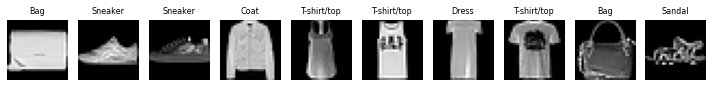

In [40]:
x_batch, y_batch = next(iter(train_loader))
print("x_batch:", x_batch.shape, "y_batch:", y_batch.shape)

plt.figure(figsize=(10, 3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    img = x_batch[i][0].cpu()  # (28,28)
    plt.imshow(img, cmap="gray")
    plt.title(class_names[y_batch[i].item()], fontsize=8)
    plt.axis("off")
plt.tight_layout()
plt.show()


## 4 — model: “tak jak w ćw. 8–11”, tylko w torch

 conv → relu → pool → conv → relu → pool → flatten → linear.

In [41]:
class ProstaCNN(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        # blok 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)  # "same"
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)  # 28->14

        # blok 2
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1) # "same"
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)  # 14->7

        # koniec: flatten -> linear
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(16 * 7 * 7, n_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        logits = self.fc(x)  # logits (bez softmax) — CrossEntropyLoss robi softmax “w środku”
        return logits

model = ProstaCNN(n_classes=10).to(device)
conv1_w_init = model.conv1.weight.detach().cpu().clone()  # zapis do porównania: przed treningiem
print(model)

ProstaCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=784, out_features=10, bias=True)
)


## 5 — “kontrola kształtów”

To jest analogia do sprawdzania shape w ćwiczeniach 9–10.

In [42]:
with torch.no_grad():
    x = x_batch[:4].to(device)  # 4 próbki
    print("wejście:", x.shape)

    a1 = model.conv1(x)
    print("po conv1:", a1.shape)

    a1r = model.relu1(a1)
    a1p = model.pool1(a1r)
    print("po relu+pool1:", a1p.shape)

    a2 = model.conv2(a1p)
    print("po conv2:", a2.shape)

    a2p = model.pool2(model.relu2(a2))
    print("po relu+pool2:", a2p.shape)

    v = model.flatten(a2p)
    print("po flatten:", v.shape)

    logits = model.fc(v)
    print("logits:", logits.shape)


wejście: torch.Size([4, 1, 28, 28])
po conv1: torch.Size([4, 8, 28, 28])
po relu+pool1: torch.Size([4, 8, 14, 14])
po conv2: torch.Size([4, 16, 14, 14])
po relu+pool2: torch.Size([4, 16, 7, 7])
po flatten: torch.Size([4, 784])
logits: torch.Size([4, 10])


## 6 — pętla treningowa (krótka, czytelna)

In [43]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def accuracy_from_logits(logits, y):
    pred = logits.argmax(dim=1)
    return (pred == y).float().mean().item()

def evaluate(model, loader):
    model.eval()
    total_acc = 0.0
    total_loss = 0.0
    n_batches = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fn(logits, y)
            total_loss += loss.item()
            total_acc += accuracy_from_logits(logits, y)
            n_batches += 1

    return total_loss / n_batches, total_acc / n_batches

def train_one_epoch(model, loader):
    model.train()
    total_acc = 0.0
    total_loss = 0.0
    n_batches = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += accuracy_from_logits(logits, y)
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches


## 7 — trening (np. 5 epok) i wykresy

Epoch 01 | train loss 0.6673 acc 0.7669 | test loss 0.4542 acc 0.8355
Epoch 02 | train loss 0.4198 acc 0.8512 | test loss 0.4224 acc 0.8483
Epoch 03 | train loss 0.3772 acc 0.8680 | test loss 0.4094 acc 0.8535
Epoch 04 | train loss 0.3563 acc 0.8742 | test loss 0.3693 acc 0.8680
Epoch 05 | train loss 0.3360 acc 0.8821 | test loss 0.3505 acc 0.8770


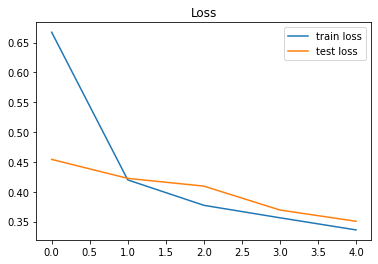

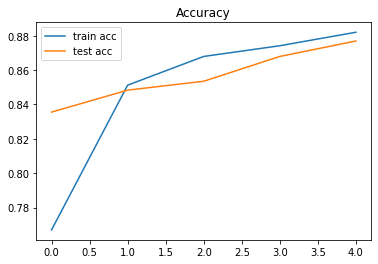

In [44]:
train_losses, train_accs = [], []
test_losses, test_accs = [], []

epochs = 5
for epoch in range(1, epochs+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    te_loss, te_acc = evaluate(model, test_loader)

    train_losses.append(tr_loss); train_accs.append(tr_acc)
    test_losses.append(te_loss); test_accs.append(te_acc)

    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | test loss {te_loss:.4f} acc {te_acc:.4f}")

plt.figure()
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.figure()
plt.plot(train_accs, label="train acc")
plt.plot(test_accs, label="test acc")
plt.legend()
plt.title("Accuracy")
plt.show()


## 8 — “z życia”: predykcja na kilku obrazkach

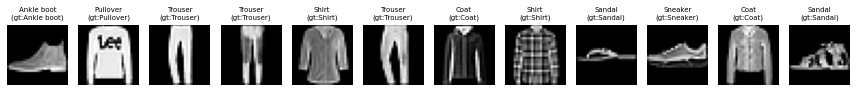

In [45]:
model.eval()
x, y = next(iter(test_loader))
x, y = x.to(device), y.to(device)

with torch.no_grad():
    logits = model(x[:12])
    pred = logits.argmax(dim=1)

plt.figure(figsize=(12, 3))
for i in range(12):
    plt.subplot(1, 12, i+1)
    img = x[i][0].cpu()
    plt.imshow(img, cmap="gray")
    gt = class_names[y[i].item()]
    pr = class_names[pred[i].item()]
    plt.title(f"{pr}\n(gt:{gt})", fontsize=7)
    plt.axis("off")
plt.tight_layout()
plt.show()


## 8b — (bonus) Gdzie model się myli? Confusion matrix + przykłady błędów

To jest świetny moment, żeby zobaczyć:
- które klasy mylą się najczęściej (np. *shirt* vs *t‑shirt*),
- jakie są typowe “trudne przypadki”.



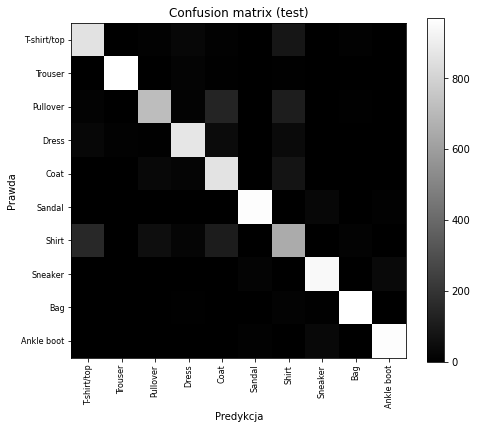

Top 10 najczęstszych pomyłek (true -> pred):
 1.      Shirt -> T-shirt/top | count=154
 2.   Pullover -> Coat       | count=139
 3.   Pullover -> Shirt      | count=112
 4.      Shirt -> Coat       | count=107
 5. T-shirt/top -> Shirt      | count=87
 6.       Coat -> Shirt      | count=79
 7.      Shirt -> Pullover   | count=53
 8.      Dress -> Coat       | count=42
 9.      Dress -> Shirt      | count=41
10.    Sneaker -> Ankle boot | count=37

Liczba błędów na teście: 1245 / 10000


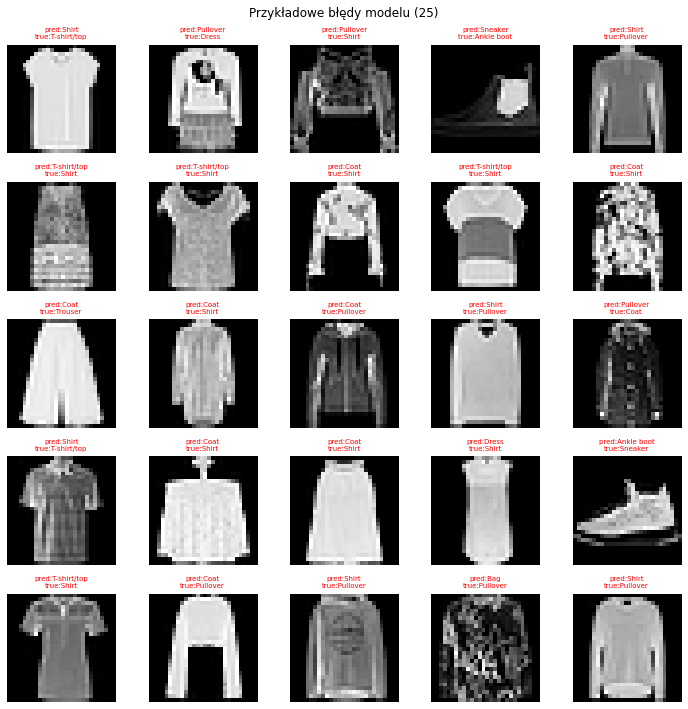

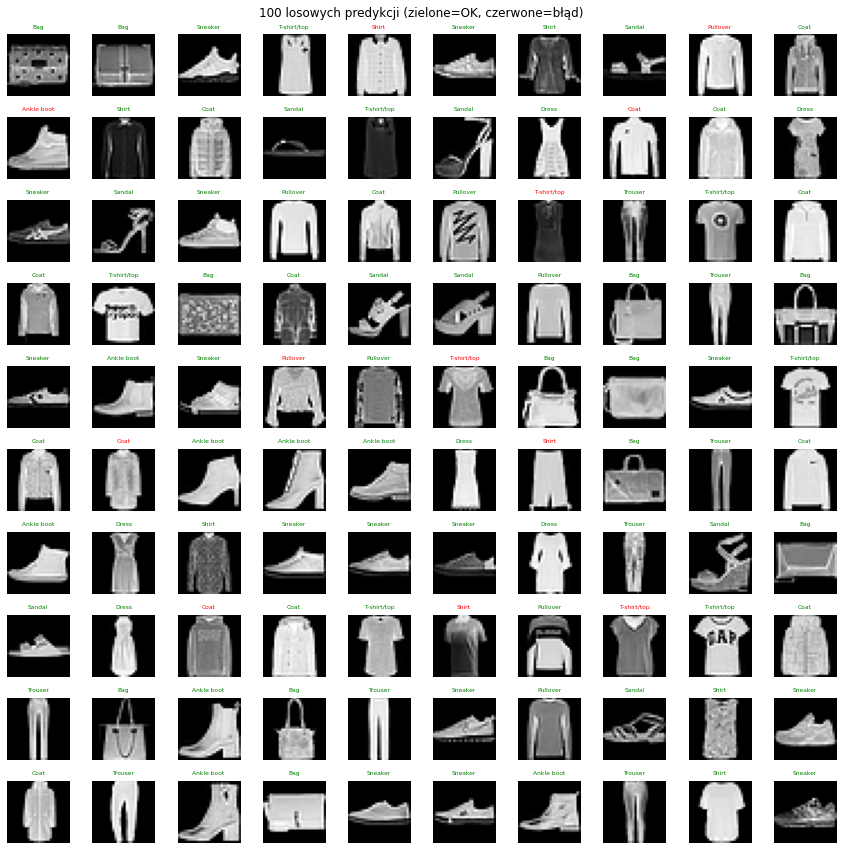

In [46]:
# --- Confusion matrix + przykłady błędów (test set) ---

import torch
import numpy as np
import matplotlib.pyplot as plt

model.eval()

all_preds = []
all_targets = []
all_imgs = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        logits = model(xb)
        pred = logits.argmax(dim=1)

        all_preds.append(pred.cpu())
        all_targets.append(yb.cpu())
        all_imgs.append(xb.cpu())

preds = torch.cat(all_preds)      # (N,)
targets = torch.cat(all_targets)  # (N,)
imgs = torch.cat(all_imgs)        # (N, 1, 28, 28)

n_classes = len(class_names)

# Confusion matrix: cm[true, pred]
cm = torch.zeros((n_classes, n_classes), dtype=torch.int64)
for t, p in zip(targets, preds):
    cm[t, p] += 1

plt.figure(figsize=(7, 6))
plt.imshow(cm, cmap="gray")
plt.title("Confusion matrix (test)")
plt.xlabel("Predykcja")
plt.ylabel("Prawda")
plt.xticks(range(n_classes), class_names, rotation=90, fontsize=8)
plt.yticks(range(n_classes), class_names, fontsize=8)
plt.colorbar()
plt.tight_layout()
plt.show()

# Najczęstsze pomyłki (poza przekątną)
cm_np = cm.numpy().copy()
np.fill_diagonal(cm_np, 0)
top = np.dstack(np.unravel_index(np.argsort(cm_np.ravel())[::-1], cm_np.shape))[0]

print("Top 10 najczęstszych pomyłek (true -> pred):")
for i in range(10):
    t, p = top[i]
    print(f"{i+1:2d}. {class_names[t]:>10s} -> {class_names[p]:<10s} | count={cm_np[t,p]}")

# Przykłady błędów (25 losowych)
mis_idx = (preds != targets).nonzero(as_tuple=False).squeeze()
print(f"\nLiczba błędów na teście: {mis_idx.numel()} / {targets.numel()}")

if mis_idx.numel() > 0:
    k = min(25, mis_idx.numel())
    sel = mis_idx[torch.randperm(mis_idx.numel())[:k]]

    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(sel):
        plt.subplot(5, 5, i + 1)
        img = imgs[idx][0]
        t = class_names[int(targets[idx])]
        p = class_names[int(preds[idx])]
        plt.imshow(img, cmap="gray")
        plt.title(f"pred:{p}\ntrue:{t}", fontsize=7, color="red")
        plt.axis("off")
    plt.suptitle("Przykładowe błędy modelu (25)")
    plt.tight_layout()
    plt.show()


# --- 100 losowych predykcji (zielone = OK, czerwone = błąd) ---

k = 100
sel = torch.randperm(targets.numel())[:k]

plt.figure(figsize=(12, 12))
for i, idx in enumerate(sel):
    plt.subplot(10, 10, i + 1)
    img = imgs[idx][0]
    t = class_names[int(targets[idx])]
    p = class_names[int(preds[idx])]
    ok = (t == p)
    plt.imshow(img, cmap="gray")
    plt.title(p, fontsize=6, color=("green" if ok else "red"))
    plt.axis("off")

plt.suptitle("100 losowych predykcji (zielone=OK, czerwone=błąd)")
plt.tight_layout()
plt.show()


### Co tak naprawdę „nauczyła się” pierwsza warstwa? (feature learning)

W CNN **filtry nie są z góry ustawione** (jak Sobel / Laplacian).  
One są **uczone z danych**: gradienty aktualizują wagi w `conv1`.

W tym notebooku zapisaliśmy kopię wag `conv1` **przed treningiem**:

- `conv1_w_init` — wagi losowe (start)
- `model.conv1.weight` — wagi po treningu (to, czego sieć się nauczyła)

Poniżej zobaczysz:

1) porównanie filtrów **przed vs po treningu**,  
2) jak te filtry “pasują” do klasycznych kerneli (Sobel/Laplacian),  
3) mapy aktywacji po `conv1` i po `ReLU` dla jednego obrazka.

To jest świetny moment na rozmowę o *feature learning*.



conv1: liczba filtrów F=8, rozmiar kernela=3×3
Skala do wizualizacji (symetryczna): vmin=-0.8719, vmax=0.8719


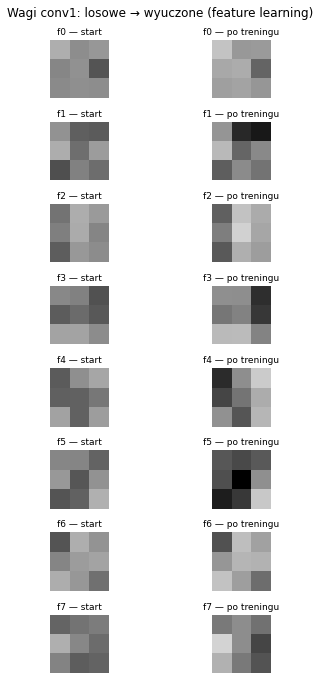


Najbardziej podobny klasyczny filtr dla każdego wyuczonego filtra (po treningu):
f0: best≈ Blur       sim= 0.778   |  Blur: 0.78, Sharpen: 0.24, Sobel X:-0.47, Sobel Y:-0.04, Laplacian:-0.20
f1: best≈ Sobel Y    sim= 0.432   |  Blur:-0.35, Sharpen:-0.15, Sobel X:-0.37, Sobel Y: 0.43, Laplacian: 0.14
f2: best≈ Blur       sim= 0.558   |  Blur: 0.56, Sharpen: 0.33, Sobel X: 0.46, Sobel Y:-0.12, Laplacian:-0.27
f3: best≈ Sobel Y    sim= 0.451   |  Blur:-0.02, Sharpen: 0.02, Sobel X:-0.57, Sobel Y: 0.45, Laplacian:-0.03
f4: best≈ Sobel X    sim= 0.756   |  Blur: 0.02, Sharpen:-0.02, Sobel X: 0.76, Sobel Y:-0.06, Laplacian: 0.01
f5: best≈ Sobel X    sim= 0.412   |  Blur:-0.61, Sharpen:-0.42, Sobel X: 0.41, Sobel Y: 0.02, Laplacian: 0.37
f6: best≈ Blur       sim= 0.619   |  Blur: 0.62, Sharpen: 0.14, Sobel X: 0.11, Sobel Y:-0.01, Laplacian:-0.08
f7: best≈ Blur       sim= 0.087   |  Blur: 0.09, Sharpen: 0.06, Sobel X:-0.90, Sobel Y:-0.03, Laplacian:-0.04

Przykład: wartości filtra f0 po treni

In [47]:
# --- (1) Filtry conv1: przed vs po treningu ---

import numpy as np
import matplotlib.pyplot as plt

w0 = conv1_w_init.detach().cpu().squeeze(1).numpy()          # (F, kH, kW)  -- przed treningiem
w1 = model.conv1.weight.detach().cpu().squeeze(1).numpy()    # (F, kH, kW)  -- po treningu

F, kH, kW = w1.shape
m = float(np.max(np.abs(np.concatenate([w0.reshape(-1), w1.reshape(-1)]))))

print(f"conv1: liczba filtrów F={F}, rozmiar kernela={kH}×{kW}")
print(f"Skala do wizualizacji (symetryczna): vmin=-{m:.4f}, vmax={m:.4f}")

fig, axes = plt.subplots(F, 2, figsize=(6, 1.2*F))
for i in range(F):
    axes[i,0].imshow(w0[i], cmap="gray", vmin=-m, vmax=m)
    axes[i,0].set_title(f"f{i} — start", fontsize=9)
    axes[i,0].axis("off")

    axes[i,1].imshow(w1[i], cmap="gray", vmin=-m, vmax=m)
    axes[i,1].set_title(f"f{i} — po treningu", fontsize=9)
    axes[i,1].axis("off")

plt.suptitle("Wagi conv1: losowe → wyuczone (feature learning)")
plt.tight_layout()
plt.show()

# --- (2) Czy wyuczone filtry przypominają klasyczne kernele? (cosine similarity) ---

classic = {
    "Blur": np.ones((3,3), dtype=np.float32)/9.0,
    "Sharpen": np.array([[0,-1,0],[-1,5,-1],[0,-1,0]], dtype=np.float32),
    "Sobel X": np.array([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=np.float32),
    "Sobel Y": np.array([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=np.float32),
    "Laplacian": np.array([[0,1,0],[1,-4,1],[0,1,0]], dtype=np.float32),
}

def cos_sim(a, b, eps=1e-8):
    a = a.reshape(-1).astype(np.float32)
    b = b.reshape(-1).astype(np.float32)
    return float(np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b) + eps))

print("\nNajbardziej podobny klasyczny filtr dla każdego wyuczonego filtra (po treningu):")
for i in range(F):
    sims = {name: cos_sim(w1[i], k) for name, k in classic.items()}
    best = max(sims, key=sims.get)
    print(f"f{i}: best≈ {best:9s}  sim={sims[best]: .3f}   |  " +
          ", ".join([f"{k}:{v: .2f}" for k,v in sims.items()]))

# (opcjonalnie) pokaż wartości jednej wagi jako liczby
i_show = 0
print(f"\nPrzykład: wartości filtra f{i_show} po treningu (3×3):\n", np.round(w1[i_show], 3))


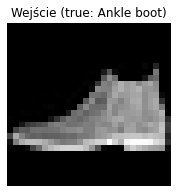

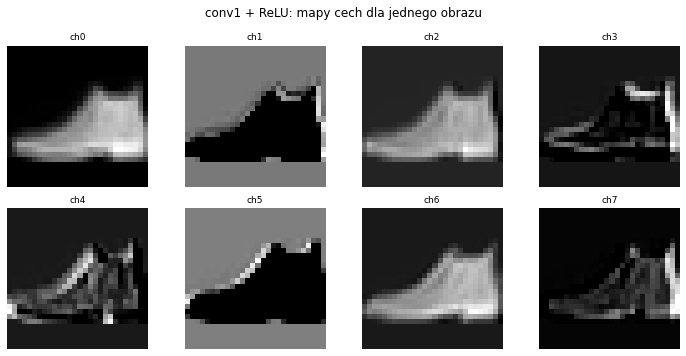

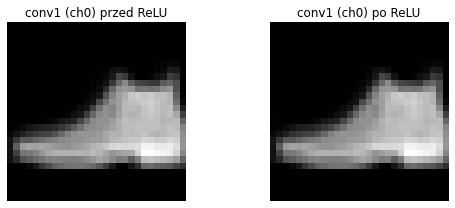

ch0: min/max przed ReLU = 0.170/1.651, po ReLU = 0.170/1.651
ch0: % zer po ReLU = 0.0%


In [48]:
# --- (3) Mapy aktywacji po conv1 (przed i po ReLU) dla jednego obrazu ---

import numpy as np
import matplotlib.pyplot as plt
import torch

model.eval()
xb, yb = next(iter(test_loader))

x0 = xb[0:1].to(device)  # (1,1,28,28)
y0 = int(yb[0].item())

with torch.no_grad():
    a_pre = model.conv1(x0)          # (1,F,28,28)  -- przed ReLU (mogą być ujemne)
    a_relu = model.relu1(a_pre)      # (1,F,28,28)  -- po ReLU (ujemne → 0)

img = x0[0,0].cpu().numpy()

plt.figure(figsize=(3,3))
plt.imshow(img, cmap="gray")
plt.title(f"Wejście (true: {class_names[y0]})")
plt.axis("off")
plt.show()

# Pokaż mapy cech po ReLU (czyli “co filtr wykrył”)
F = a_relu.shape[1]
n_show = min(F, 8)

plt.figure(figsize=(10,5))
for i in range(n_show):
    plt.subplot(2, 4, i+1)
    fm = a_relu[0,i].cpu().numpy()
    plt.imshow(fm, cmap="gray")
    plt.title(f"ch{i}", fontsize=9)
    plt.axis("off")
plt.suptitle("conv1 + ReLU: mapy cech dla jednego obrazu")
plt.tight_layout()
plt.show()

# Dodatkowo: dla 1 kanału pokaż różnicę przed vs po ReLU
ch = 0
pre = a_pre[0,ch].cpu().numpy()
post = a_relu[0,ch].cpu().numpy()

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); plt.imshow(pre, cmap="gray");  plt.title(f"conv1 (ch{ch}) przed ReLU"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(post, cmap="gray"); plt.title(f"conv1 (ch{ch}) po ReLU"); plt.axis("off")
plt.tight_layout()
plt.show()

print(f"ch{ch}: min/max przed ReLU = {pre.min():.3f}/{pre.max():.3f}, po ReLU = {post.min():.3f}/{post.max():.3f}")
print(f"ch{ch}: % zer po ReLU = {(post==0).mean()*100:.1f}%")


### Mini‑ćwiczenie (bardzo polecam): czy `Conv2d` w PyTorch robi to samo co Twoja `conv2d_same`?

W PyTorch `Conv2d` liczy **korelację** (bez flipu kernela) + zwykle używa **zero‑paddingu**.

**Zadanie:**

1. Weź jeden wyuczony filtr z `conv1`.  
2. Policzyć mapę cech na 2 sposoby:
   - (A) PyTorch: `model.conv1(x0)[0, ch]`
   - (B) Twoja implementacja: `conv2d_same(img, kernel, pad_mode="zero")`
3. Porównaj wyniki (powinny być prawie identyczne).

Poniżej jest gotowe rozwiązanie.



max |diff|: 0.17487561702728271
mean|diff|: 0.17487549781799316


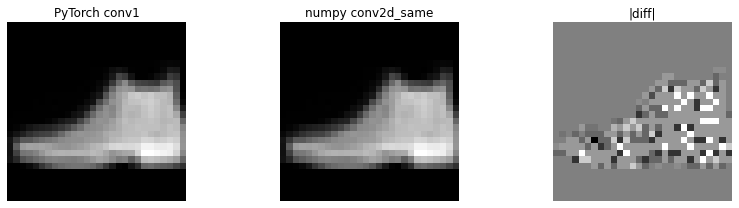

In [49]:
# --- Rozwiązanie mini‑ćwiczenia: porównanie PyTorch vs numpy conv2d_same ---

import numpy as np
import matplotlib.pyplot as plt

# Weź tę samą próbkę co wcześniej (img) oraz wyuczony filtr (w1)
ch = 0
kernel = model.conv1.weight.detach().cpu().squeeze(1).numpy()[ch]  # (3,3)

# (A) PyTorch (przed ReLU)
with torch.no_grad():
    y_torch = model.conv1(x0)[0, ch].cpu().numpy()

# (B) numpy: nasza korelacja + zero padding (żeby było 1:1)
y_np = conv2d_same(img, kernel, pad_mode="zero")

diff = np.abs(y_torch - y_np)
print("max |diff|:", float(diff.max()))
print("mean|diff|:", float(diff.mean()))

plt.figure(figsize=(12,3))
plt.subplot(1,3,1); plt.imshow(y_torch, cmap="gray"); plt.title("PyTorch conv1"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(y_np, cmap="gray");    plt.title("numpy conv2d_same"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(diff, cmap="gray");    plt.title("|diff|"); plt.axis("off")
plt.tight_layout()
plt.show()


# ĆWICZENIE do wykonania

Proszę teraz przeprowadzić kilka eksperymentów i sprawdzić wpływ różnych wariantów ustawień sieci (**padding, stride, pool**) na:
- **szybkość uczenia** (czas epoki / liczba batchy),
- **zbieżność** (loss w czasie),
- **jakość predykcji** (accuracy na zbiorze testowym).

**Jak pracujesz?**
1. Zmieniasz tylko parametry w słowniku `experiments` (na początku komórki).
2. Uruchamiasz komórkę.
3. Porównujesz wyniki w tabeli (loss/acc + czas).

**Sugestie wariantów (zrób przynajmniej 3):**
- `padding=1` vs `padding=0` (czyli „same” vs „valid”),
- `stride=1` vs `stride=2` w `conv` (czasem można wtedy ograniczyć pooling),
- `maxpool` vs `avgpool`,
- pooling tylko po pierwszej konwolucji vs pooling po obu konwolucjach.

> Wskazówka: dla szybkich testów ustaw `MAX_BATCHES` na np. 100–200 (zamiast pełnej epoki).


Device: cpu | epochs=2 | train_batches=150 | test_batches=None

[baseline_same+maxpool] feature shape=(1, 32, 7, 7) -> flat_dim=1568
[baseline_same+maxpool] ep 01/2 | train loss 0.8923 acc 0.696 | test loss 0.6297 acc 0.749 | 121.1s
[baseline_same+maxpool] ep 02/2 | train loss 0.5108 acc 0.816 | test loss 0.4669 acc 0.833 | 35.6s

[valid_no_padding] feature shape=(1, 32, 5, 5) -> flat_dim=800
[valid_no_padding] ep 01/2 | train loss 1.0002 acc 0.662 | test loss 0.6490 acc 0.758 | 33.9s
[valid_no_padding] ep 02/2 | train loss 0.5762 acc 0.787 | test loss 0.5477 acc 0.798 | 36.1s


=== PODSUMOWANIE (ostatnia epoka) ===
baseline_same+maxpool  | test_acc=0.833 | test_loss=0.4669 | sec/ep≈78.4
valid_no_padding       | test_acc=0.798 | test_loss=0.5477 | sec/ep≈35.0


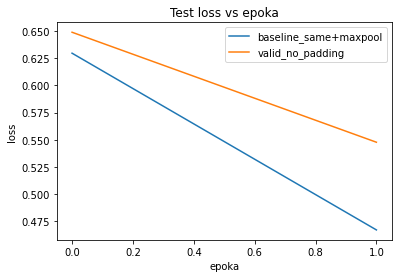

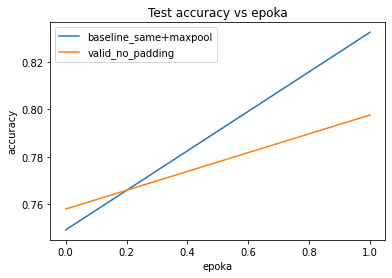

In [67]:
# ================================
# Eksperymenty: padding / stride / pooling
# (tu nie piszesz nowej implementacji — tylko zmieniasz parametry)
# ================================

import time
from collections import OrderedDict

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# TODO student: ZMIENIAJ TYLKO TĘ SEKCJĘ
# ------------------------------------------------------------
EPOCHS = 2
LR = 1e-3

# Dla szybkich testów możesz ograniczyć liczbę batchy na epokę:
# - None         -> pełna epoka (wolniej, dokładniej)
# - 100 / 200    -> szybciej (w sam raz na ćwiczenia)
MAX_TRAIN_BATCHES = 150

# Test możesz liczyć na całości (polecam) albo też ograniczyć:
MAX_TEST_BATCHES = None

# Opis eksperymentów:
# - conv1/conv2: parametry warstw konwolucyjnych
# - pool1/pool2: parametry pooling (None => brak pooling w tym miejscu)
experiments = OrderedDict({

    # --- (A) BASELINE: klasyczne "same conv + maxpool" ---
    "baseline_same+maxpool": dict(
        conv1=dict(out_channels=16, kernel_size=3, stride=1, padding=1),
        conv2=dict(out_channels=32, kernel_size=3, stride=1, padding=1),
        pool1=dict(type="max", kernel_size=2, stride=2),
        pool2=dict(type="max", kernel_size=2, stride=2),
    ),

    # --- (B) PRZYKŁADOWE ROZWIĄZANIE: bez paddingu ("valid") ---
    "valid_no_padding": dict(
        conv1=dict(out_channels=16, kernel_size=3, stride=1, padding=0),
        conv2=dict(out_channels=32, kernel_size=3, stride=1, padding=0),
        pool1=dict(type="max", kernel_size=2, stride=2),
        pool2=dict(type="max", kernel_size=2, stride=2),
    ),

    # ------------------------------------------------------------
    # TODO (Twoje warianty): dopisz swoje eksperymenty poniżej.
    # Podpowiedź: zmień stride albo typ pooling (np. avg).
    # ------------------------------------------------------------
    # "stride2_no_pool2": dict(
    #     conv1=dict(out_channels=16, kernel_size=3, stride=2, padding=1),
    #     conv2=dict(out_channels=32, kernel_size=3, stride=2, padding=1),
    #     pool1=dict(type="max", kernel_size=2, stride=2),
    #     pool2=None,  # brak pooling po conv2
    # ),
})

# ------------------------------------------------------------
# ❗ Reszty kodu nie musisz zmieniać.
# ------------------------------------------------------------

# Szybka walidacja: upewniamy się, że masz przygotowane dane z poprzednich komórek.
assert "train_loader" in globals() and "test_loader" in globals(), (
    "Nie widzę train_loader/test_loader. "
    "Uruchom wcześniej komórki z przygotowaniem danych (FashionMNIST)."
)

def _make_pool(spec):
    if spec is None:
        return nn.Identity()
    t = spec.get("type", "max").lower()
    k = spec.get("kernel_size", 2)
    s = spec.get("stride", k)
    if t in ["max", "maxpool", "max_pool"]:
        return nn.MaxPool2d(kernel_size=k, stride=s)
    if t in ["avg", "avgpool", "avg_pool"]:
        return nn.AvgPool2d(kernel_size=k, stride=s)
    if t in ["none", "identity"]:
        return nn.Identity()
    raise ValueError(f"Nieznany typ pooling: {t}")

class FlexibleCNN(nn.Module):
    """Mała CNN, ale parametryzowana (padding/stride/pool).

    Uwaga: rozmiar wejścia zakładamy jak w FashionMNIST: 1×28×28.
    Jeśli zmienisz dane, ustaw input_hw.
    """
    def __init__(self, cfg, num_classes=10, in_channels=1, input_hw=(28, 28)):
        super().__init__()
        c1 = cfg["conv1"]
        c2 = cfg["conv2"]
        p1 = cfg.get("pool1", None)
        p2 = cfg.get("pool2", None)

        self.features = nn.Sequential(
            nn.Conv2d(in_channels, c1["out_channels"], kernel_size=c1["kernel_size"],
                      stride=c1["stride"], padding=c1["padding"]),
            nn.ReLU(),
            _make_pool(p1),

            nn.Conv2d(c1["out_channels"], c2["out_channels"], kernel_size=c2["kernel_size"],
                      stride=c2["stride"], padding=c2["padding"]),
            nn.ReLU(),
            _make_pool(p2),
        )

        # Automatycznie wyliczamy rozmiar wektora po flatten
        # (żeby dało się zmieniać stride/pool/padding bez liczenia ręcznie).
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, input_hw[0], input_hw[1])
            out = self.features(dummy)
            flat_dim = out.view(1, -1).shape[1]

        self.classifier = nn.Linear(flat_dim, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)     # flatten
        x = self.classifier(x)        # logits
        return x

def seed_everything(seed=42):
    import random, numpy as np
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_one_epoch(model, loader, loss_fn, optimizer, device, max_batches=None):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for i, (x, y) in enumerate(loader):
        if (max_batches is not None) and (i >= max_batches):
            break
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total

@torch.no_grad()
def eval_model(model, loader, loss_fn, device, max_batches=None):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    for i, (x, y) in enumerate(loader):
        if (max_batches is not None) and (i >= max_batches):
            break
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = loss_fn(logits, y)

        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total

def run_experiment(name, cfg, epochs=2, lr=1e-3,
                   max_train_batches=150, max_test_batches=None, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    seed_everything(42)
    model = FlexibleCNN(cfg).to(device)

    # Szybka kontrola kształtów (zobacz, jak padding/stride/pool zmienia rozmiar map cech)
    with torch.no_grad():
        dummy = torch.zeros(1, 1, 28, 28, device=device)
        feat = model.features(dummy)
        flat_dim = feat.view(1, -1).shape[1]
        print(f"[{name}] feature shape={tuple(feat.shape)} -> flat_dim={flat_dim}")
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    hist = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": [], "sec_per_epoch": []}

    for ep in range(1, epochs + 1):
        t0 = time.perf_counter()
        tr_loss, tr_acc = train_one_epoch(
            model, train_loader, loss_fn, optimizer, device,
            max_batches=max_train_batches
        )
        te_loss, te_acc = eval_model(
            model, test_loader, loss_fn, device,
            max_batches=max_test_batches
        )
        dt = time.perf_counter() - t0

        hist["train_loss"].append(tr_loss)
        hist["train_acc"].append(tr_acc)
        hist["test_loss"].append(te_loss)
        hist["test_acc"].append(te_acc)
        hist["sec_per_epoch"].append(dt)

        print(f"[{name}] ep {ep:02d}/{epochs} | "
              f"train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
              f"test loss {te_loss:.4f} acc {te_acc:.3f} | "
              f"{dt:.1f}s")

    return hist

# ------------------------
# Uruchom wszystkie eksperymenty
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_hist = {}

print(f"Device: {device} | epochs={EPOCHS} | "
      f"train_batches={MAX_TRAIN_BATCHES} | test_batches={MAX_TEST_BATCHES}\n")

for name, cfg in experiments.items():
    all_hist[name] = run_experiment(
        name, cfg,
        epochs=EPOCHS,
        lr=LR,
        max_train_batches=MAX_TRAIN_BATCHES,
        max_test_batches=MAX_TEST_BATCHES,
        device=device
    )
    print()

# ------------------------
# Podsumowanie (ostatnia epoka)
# ------------------------
print("\n=== PODSUMOWANIE (ostatnia epoka) ===")
for name, h in all_hist.items():
    sec = sum(h["sec_per_epoch"]) / len(h["sec_per_epoch"])
    print(f"{name:22s} | test_acc={h['test_acc'][-1]:.3f} | "
          f"test_loss={h['test_loss'][-1]:.4f} | sec/ep≈{sec:.1f}")

# ------------------------
# Wykresy: loss i accuracy (test)
# ------------------------
plt.figure()
for name, h in all_hist.items():
    plt.plot(h["test_loss"], label=name)
plt.title("Test loss vs epoka")
plt.xlabel("epoka")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.figure()
for name, h in all_hist.items():
    plt.plot(h["test_acc"], label=name)
plt.title("Test accuracy vs epoka")
plt.xlabel("epoka")
plt.ylabel("accuracy")
plt.legend()
plt.show()


# Ćwiczenie 12 ⭐ – XOR: jedna warstwa nie wystarczy, dwie warstwy + ReLU działa (PyTorch) 
# Nawiązanie do tych długich 2 pierwszych zajęć i robienia backpropagation ręcznie i w arkuszu :)
## 12.1. Dane XOR + wykres 

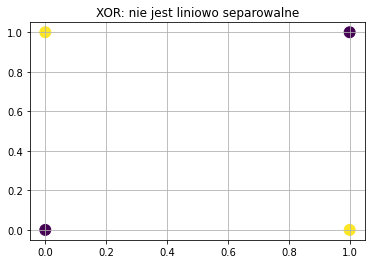

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# XOR
X = torch.tensor([[0.,0.],
                  [0.,1.],
                  [1.,0.],
                  [1.,1.]], dtype=torch.float32)
y = torch.tensor([0,1,1,0], dtype=torch.long)

plt.figure()
plt.scatter(X[:,0], X[:,1], c=y, s=120)
plt.title("XOR: nie jest liniowo separowalne")
plt.grid(True)
plt.show()


## 12.2. Model 1: jedna warstwa (zwykle polegnie)

In [51]:
model1 = nn.Linear(2, 2)  # 2 klasy
opt1 = optim.SGD(model1.parameters(), lr=0.2)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(2000):
    opt1.zero_grad()
    logits = model1(X)
    loss = loss_fn(logits, y)
    loss.backward()
    opt1.step()

with torch.no_grad():
    pred = model1(X).argmax(dim=1)
    acc = (pred == y).float().mean().item()
print("1 warstwa — pred:", pred.tolist(), "acc:", acc)


1 warstwa — pred: [0, 1, 0, 1] acc: 0.5


## 12.3. Model 2: dwie warstwy + ReLU (powinno dojść do 100%)

In [53]:
model2 = nn.Sequential(
    nn.Linear(2, 8),
    nn.ReLU(),
    nn.Linear(8, 2)
)
opt2 = optim.Adam(model2.parameters(), lr=0.05)

for epoch in range(2000):
    opt2.zero_grad()
    logits = model2(X)
    loss = loss_fn(logits, y)
    loss.backward()
    opt2.step()

with torch.no_grad():
    pred2 = model2(X).argmax(dim=1)
    acc2 = (pred2 == y).float().mean().item()
print("2 warstwy + ReLU — pred:", pred2.tolist(), "acc:", acc2)


2 warstwy + ReLU — pred: [0, 1, 1, 0] acc: 1.0


## 12.4. (Opcjonalnie) Granice decyzyjne 

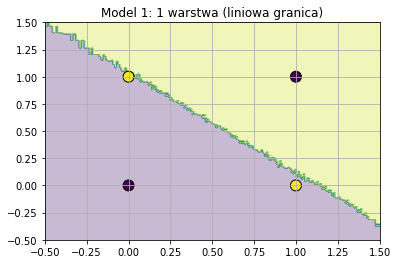

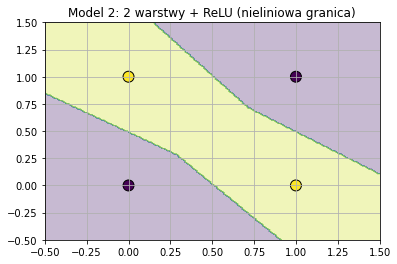

In [54]:
def plot_boundary(model, title):
    xs = np.linspace(-0.5, 1.5, 200)
    ys = np.linspace(-0.5, 1.5, 200)
    xx, yy = np.meshgrid(xs, ys)
    grid = np.stack([xx.ravel(), yy.ravel()], axis=1)
    grid_t = torch.tensor(grid, dtype=torch.float32)

    with torch.no_grad():
        zz = model(grid_t).argmax(dim=1).numpy().reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, zz, alpha=0.3)
    plt.scatter(X[:,0], X[:,1], c=y, s=120, edgecolors="k")
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_boundary(model1, "Model 1: 1 warstwa (liniowa granica)")
plot_boundary(model2, "Model 2: 2 warstwy + ReLU (nieliniowa granica)")


# ⭐ DODATEK (nieobowiązkowy, do końca): MLP / warstwy gęste i XOR (opcjonalnie)

Ta część jest przydatna, jeśli chcesz *domknąć intuicję*, dlaczego:
- jedna warstwa liniowa nie wystarczy na problemy nieliniowe,
- potrzebujemy nieliniowości (np. ReLU),
- i jak to się łączy z tym, co robi CNN na końcu (flatten + linear).
# Dodawanie kolejnych warstw do sieci
# Regresja vs klasyfikacja — krótko i jasno

**Tak, to inny typ zadania.  
Nie, to nie jest inny mechanizm uczenia.**

---

## Co jest takie samo
- ta sama sieć (warstwy, wagi),
- ten sam algorytm uczenia (backpropagation),
- te same gradienty i optymalizacja.

> **Uczenie jest identyczne.**

---

## Co się różni
Różnica dotyczy **tylko wyjścia i funkcji straty**.

### Regresja
- wyjście: liczba rzeczywista  
- przykład lossu: MSE  
$
L = (y - \hat y)^2
$

### Klasyfikacja (np. XOR)
- wyjście: prawdopodobieństwo klasy  
- przykład lossu: cross-entropy  
$
L = -\big(y\log p + (1-y)\log(1-p)\big)
$

---

## Najważniejszy wniosek
> **Warstwy ukryte działają identycznie w regresji i klasyfikacji.**  
> Różnica pojawia się dopiero na samym końcu sieci.

---

## Dlaczego to ważne (pod CNN)
- CNN najpierw **uczy się cech** (regresja reprezentacji),
- a dopiero na końcu **klasyfikuje**.

---

## Jedno zdanie do zapamiętania
> **Regresja i klasyfikacja różnią się celem,  
> ale nie różnią się algorytmem uczenia.**

## Eksperyment 1 — „Jedna warstwa daje granicę liniową”

### Zadanie (co robi uczeń)
Zbuduj i naucz model:
$
p = \sigma(XW + b),\qquad \hat y = \mathbb{1}[p>0.5]
$
na danych 2D, które są **liniowo separowalne**.

### Cel dydaktyczny
- Zobaczyć, że **jedna warstwa** uczy się **prostej granicy** (prosta/hiperpłaszczyzna).
- Uczniowie rozumieją, że model „patrzy” na dane **jednym rzutem oka**: `X -> decyzja`.

### Przebieg (na lekcji)
1. Wygeneruj dwie chmury punktów (klasa 0 i 1).
2. Naucz `W,b` gradientowo.
3. Narysuj decision boundary jako kontur \(p=0.5\).

### Oczekiwany wynik
- Model osiąga bardzo wysoką trafność.
- Granica decyzyjna jest **linią** (w 2D).

---

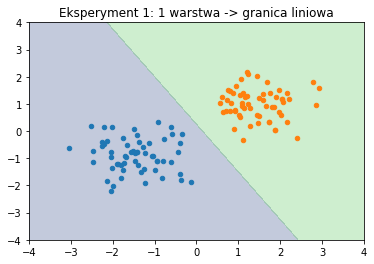

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Dane liniowo separowalne
np.random.seed(0)
n = 120
X0 = np.random.randn(n//2, 2) * 0.6 + np.array([-1.5, -1.0])
X1 = np.random.randn(n//2, 2) * 0.6 + np.array([ 1.5,  1.0])
X = np.vstack([X0, X1])
y = np.hstack([np.zeros(n//2), np.ones(n//2)]).reshape(-1,1)

# Jedna warstwa: sigmoid(Wx + b)
W = np.zeros((2,1))
b = np.zeros((1,))

def sigmoid(z):
    return 1/(1+np.exp(-z))
def relu(x):
    return np.maximum(0, x)
lr = 0.2
for _ in range(2000):
    z = X @ W + b
    p = sigmoid(z)
    # gradient cross-entropy
    dW = (X.T @ (p - y)) / len(X)
    db = np.mean(p - y)
    W -= lr * dW
    b -= lr * db

# Wizualizacja granicy decyzyjnej
xx, yy = np.meshgrid(np.linspace(-4,4,200), np.linspace(-4,4,200))
grid = np.c_[xx.ravel(), yy.ravel()]
pp = sigmoid(grid @ W + b).reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, pp, levels=[0,0.5,1], alpha=0.3)
plt.scatter(X0[:,0], X0[:,1], s=20)
plt.scatter(X1[:,0], X1[:,1], s=20)
plt.title("Eksperyment 1: 1 warstwa -> granica liniowa")
plt.show()


In [56]:
W = np.zeros([2,1])
b = np.zeros((1,))
W,b

(array([[0.],
        [0.]]),
 array([0.]))

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

def plot_boundary(model, X, y, title, xlim, ylim, steps=250):
    model.eval()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], steps),
                         np.linspace(ylim[0], ylim[1], steps))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_t = torch.tensor(grid, dtype=torch.float32)

    with torch.no_grad():
        logits = model(grid_t).squeeze(1)
        probs = torch.sigmoid(logits).cpu().numpy().reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, probs, levels=[0,0.5,1], alpha=0.3)
    plt.scatter(X[:,0], X[:,1], c=y, s=12)
    plt.title(title)
    plt.show()


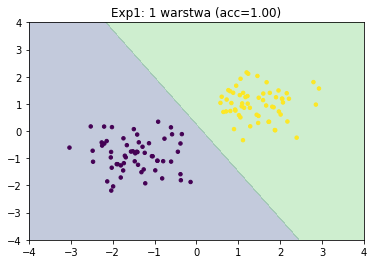

In [58]:
# Dane liniowo separowalne
np.random.seed(0)
n = 120
X0 = np.random.randn(n//2, 2) * 0.6 + np.array([-1.5, -1.0])
X1 = np.random.randn(n//2, 2) * 0.6 + np.array([ 1.5,  1.0])
X = np.vstack([X0, X1]).astype(np.float32)
y = np.hstack([np.zeros(n//2), np.ones(n//2)]).astype(np.float32)

Xt = torch.tensor(X)
yt = torch.tensor(y).unsqueeze(1)

model = nn.Linear(2, 1)   # 1 warstwa
loss_fn = nn.BCEWithLogitsLoss()
opt = optim.SGD(model.parameters(), lr=0.2)

for _ in range(2000):
    opt.zero_grad()
    logits = model(Xt)
    loss = loss_fn(logits, yt)
    loss.backward()
    opt.step()

with torch.no_grad():
    pred = (torch.sigmoid(model(Xt)) > 0.5).float()
    acc = (pred.eq(yt)).float().mean().item()

plot_boundary(model, X, y, f"Exp1: 1 warstwa (acc={acc:.2f})", xlim=(-4,4), ylim=(-4,4))


# Eksperymet 2

---



## Eksperyment 2 — „XOR: jedna warstwa przegrywa”

### Zadanie
Użyj dokładnie tego samego modelu jednowarstwowego na danych XOR.

Dla czterech punktów bazowych:
- (0,0) → 0
- (0,1) → 1
- (1,0) → 1
- (1,1) → 0

### Cel dydaktyczny
- Twardy fakt: XOR jest **nieliniowo separowalny**, więc jedna prosta nie wystarczy.
- Uczniowie mają zobaczyć, że model „kręci się” i kończy z accuracy ~0.5–0.75.

### Przebieg
1. Zbuduj XOR (często dodaje się mały szum, by ładniej wyglądało na wykresie).
2. Naucz jedną warstwę.
3. Narysuj granicę decyzji.

### Oczekiwany wynik
- Granica nadal jest linią.
- Jedna z par „wysp” XOR będzie źle sklasyfikowana.



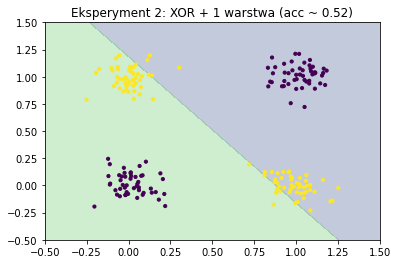

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# XOR
X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=np.float32)
y = np.array([[0],[1],[1],[0]], dtype=np.float32)

# Uprośćmy: uczymy na lekko "rozsianych" punktach, żeby było ładniej na wykresie
np.random.seed(1)
X = np.vstack([X + 0.1*np.random.randn(*X.shape) for _ in range(50)])
y = np.vstack([y for _ in range(50)])

W = np.zeros((2,1))
b = np.zeros((1,))

def sigmoid(z):
    return 1/(1+np.exp(-z))

lr = 0.5
for _ in range(4000):
    p = sigmoid(X @ W + b)
    dW = (X.T @ (p - y)) / len(X)
    db = np.mean(p - y)
    W -= lr * dW
    b -= lr * db

# accuracy
pred = (sigmoid(X @ W + b) > 0.5).astype(np.float32)
acc = (pred == y).mean()

# decision boundary
xx, yy = np.meshgrid(np.linspace(-0.5,1.5,200), np.linspace(-0.5,1.5,200))
grid = np.c_[xx.ravel(), yy.ravel()]
pp = sigmoid(grid @ W + b).reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, pp, levels=[0,0.5,1], alpha=0.3)
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=10)
plt.title(f"Eksperyment 2: XOR + 1 warstwa (acc ~ {acc:.2f})")
plt.show()


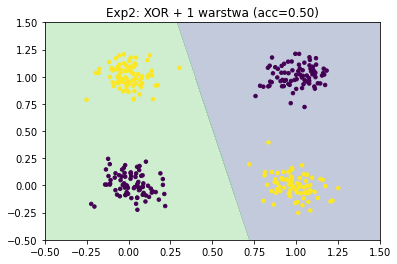

In [60]:
# XOR z szumem (żeby było ładnie) Pytorch
np.random.seed(1)
X_base = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=np.float32)
y_base = np.array([0,1,1,0], dtype=np.float32)

X = np.vstack([X_base + 0.1*np.random.randn(*X_base.shape) for _ in range(80)]).astype(np.float32)
y = np.hstack([y_base for _ in range(80)]).astype(np.float32)

Xt = torch.tensor(X)
yt = torch.tensor(y).unsqueeze(1)

model = nn.Linear(2, 1)   # nadal 1 warstwa
loss_fn = nn.BCEWithLogitsLoss()
opt = optim.SGD(model.parameters(), lr=0.5)

for _ in range(4000):
    opt.zero_grad()
    logits = model(Xt)
    loss = loss_fn(logits, yt)
    loss.backward()
    opt.step()

with torch.no_grad():
    pred = (torch.sigmoid(model(Xt)) > 0.5).float()
    acc = (pred.eq(yt)).float().mean().item()

plot_boundary(model, X, y, f"Exp2: XOR + 1 warstwa (acc={acc:.2f})", xlim=(-0.5,1.5), ylim=(-0.5,1.5))


[[-0.5        -0.48994975 -0.4798995  ...  1.4798995   1.48994975
   1.5       ]
 [-0.5        -0.48994975 -0.4798995  ...  1.4798995   1.48994975
   1.5       ]
 [-0.5        -0.48994975 -0.4798995  ...  1.4798995   1.48994975
   1.5       ]
 ...
 [-0.5        -0.48994975 -0.4798995  ...  1.4798995   1.48994975
   1.5       ]
 [-0.5        -0.48994975 -0.4798995  ...  1.4798995   1.48994975
   1.5       ]
 [-0.5        -0.48994975 -0.4798995  ...  1.4798995   1.48994975
   1.5       ]]
[-0.5        -0.48994975 -0.4798995  ...  1.4798995   1.48994975
  1.5       ]


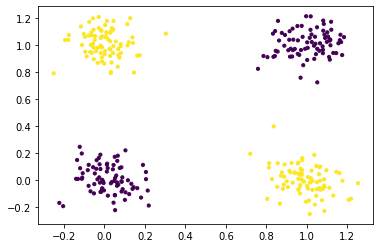

In [61]:
print(xx)
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=10)

print(xx.ravel())

# Eksperyment 3
---

## Eksperyment 3 — „XOR: dwie warstwy + nieliniowość wygrywają”

### Zadanie
Zbuduj sieć:
$
z_1 = XW_1 + b_1,\quad h = \phi(z_1),\quad
z_2 = hW_2 + b_2,\quad p = \sigma(z_2)
$
gdzie \(\phi\) to ReLU lub tanh.

### Cel dydaktyczny
- Pierwsza warstwa tworzy **nową reprezentację** \(h\).
- Druga warstwa robi prosty podział (liniowy) **w przestrzeni cech** \(h\).
- Nieliniowość \(\phi\) jest kluczowa: bez niej „dwie warstwy = jedna warstwa”.

### Przebieg
1. Naucz sieć na XOR.
2. Narysuj granicę decyzji.
3. (Opcjonalnie) Porównaj kilka seedów, aby pokazać wpływ inicjalizacji.
4. (Bardzo dydaktyczne) policz, ile neuronów ReLU jest „martwych” (patrz sekcja na końcu).

### Oczekiwany wynik
- Granica decyzji jest **nieliniowa** i potrafi „objąć” XOR.
- Przy dobrych ustawieniach: accuracy ≈ 1.0.

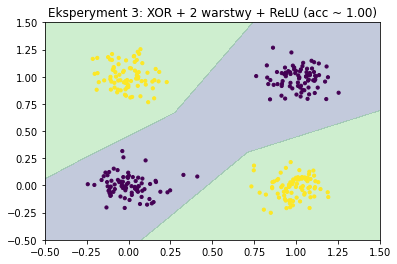

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# XOR (jak poprzednio)
np.random.seed(2)
X_base = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=np.float32)
y_base = np.array([[0],[1],[1],[0]], dtype=np.float32)
X = np.vstack([X_base + 0.1*np.random.randn(*X_base.shape) for _ in range(80)])
y = np.vstack([y_base for _ in range(80)])

# Sieć 2-warstwowa: h = ReLU(XW1+b1), p = sigmoid(hW2+b2)
H = 6  # liczba neuronów ukrytych
W1 = 0.5*np.random.randn(2, H)
b1 = np.zeros((H,))
W2 = 0.5*np.random.randn(H, 1)
b2 = np.zeros((1,))

def relu(z): return np.maximum(0, z)
def drelu(z): return (z > 0)
def sigmoid(z): return 1/(1+np.exp(-z))

lr = 0.05
for _ in range(2000):
    z1 = X @ W1 + b1
    h  = relu(z1)
    z2 = h @ W2 + b2
    p  = sigmoid(z2)

    # backprop (cross-entropy + sigmoid)
    dz2 = (p - y) / len(X)
    dW2 = h.T @ dz2
    db2 = dz2.sum(axis=0)

    dh  = dz2 @ W2.T
    dz1 = dh * drelu(z1)
    dW1 = X.T @ dz1
    db1 = dz1.sum(axis=0)

    W2 -= lr * dW2
    b2 -= lr * db2
    W1 -= lr * dW1
    b1 -= lr * db1

pred = (sigmoid(relu(X @ W1 + b1) @ W2 + b2) > 0.5).astype(np.float32)
acc = (pred == y).mean()

# Decision boundary
xx, yy = np.meshgrid(np.linspace(-0.5,1.5,250), np.linspace(-0.5,1.5,250))
grid = np.c_[xx.ravel(), yy.ravel()]
pp = sigmoid(relu(grid @ W1 + b1) @ W2 + b2).reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, pp, levels=[0,0.5,1], alpha=0.3)
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=10)
plt.title(f"Eksperyment 3: XOR + 2 warstwy + ReLU (acc ~ {acc:.2f})")
plt.show()


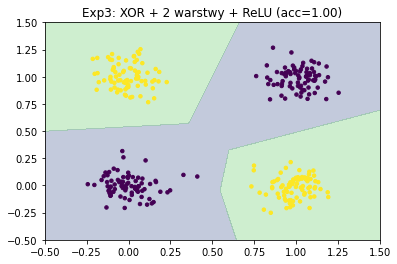

In [63]:
# XOR jak wcześniej Pytorch
np.random.seed(2)
X_base = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=np.float32)
y_base = np.array([0,1,1,0], dtype=np.float32)

X = np.vstack([X_base + 0.1*np.random.randn(*X_base.shape) for _ in range(80)]).astype(np.float32)
y = np.hstack([y_base for _ in range(80)]).astype(np.float32)

Xt = torch.tensor(X)
yt = torch.tensor(y).unsqueeze(1)

H = 8
model = nn.Sequential(
    nn.Linear(2, H),
    nn.ReLU(),
    nn.Linear(H, 1)
)

loss_fn = nn.BCEWithLogitsLoss()
opt = optim.Adam(model.parameters(), lr=0.05)  # Adam daje stabilność na lekcji

for _ in range(3000):
    opt.zero_grad()
    logits = model(Xt)
    loss = loss_fn(logits, yt)
    loss.backward()
    opt.step()

with torch.no_grad():
    pred = (torch.sigmoid(model(Xt)) > 0.5).float()
    acc = (pred.eq(yt)).float().mean().item()

plot_boundary(model, X, y, f"Exp3: XOR + 2 warstwy + ReLU (acc={acc:.2f})", xlim=(-0.5,1.5), ylim=(-0.5,1.5))


In [64]:
for name, p in model.named_parameters():
    print(name, p.grad.norm().item())


0.weight 6.981948445172748e-06
0.bias 3.3353467188135255e-06
2.weight 1.359297675662674e-05
2.bias 5.879312539036619e-07


# Eksperyment 4
Dodanie kolejnego regionu i 3 warstwy

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim

# y: etykiety 0,1,2 (dtype long), bez one-hot
loss_fn = nn.CrossEntropyLoss()  # robi softmax wewnątrz

model1 = nn.Linear(2, 3)  # 1 warstwa, 3 logity

model2 = nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 3)
)

opt = optim.Adam(model2.parameters(), lr=0.05)

trening:
logits = model2(X)
loss = loss_fn(logits, y)
loss.backward(); opt.step()


SyntaxError: invalid syntax (3424040157.py, line 18)